Import important parameter

In [1]:
inputsize =99
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 0.473942353433427
Interation = 1
Residual = 0.1283915034859425
Interation = 2
Residual = 0.05419003167139986
Interation = 3
Residual = 0.0312599219076545
Interation = 4
Residual = 0.019690999673216046
Interation = 5
Residual = 0.012740661237064015
Interation = 6
Residual = 0.008373338768327672
Interation = 7
Residual = 0.005571371689033319
Interation = 8
Residual = 0.0037441962210653292
Interation = 9
Residual = 0.002536232677445173
Interation = 10
Residual = 0.0017286788301672288
Interation = 11
Residual = 0.0011840310165926148
Interation = 12
Residual = 0.0008141584219796192
Interation = 13
Residual = 0.0005616132355186141
Interation = 14
Residual = 0.0003884326358816022
Interation = 15
Residual = 0.0002692586180203906
Interation = 16
Residual = 0.00018701024631209348
Interation = 17
Residual = 0.00013010621782250475
Interation = 18
Residual = 9.065312072634788e-05
Interation = 19
Residual = 6.324835976045301e-05
Interation = 20
Residual = 4.418125375769791e-05
Interation 

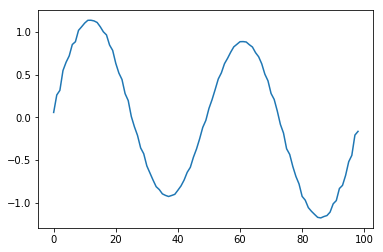

In [6]:
plt.plot(GMM_U)

In [7]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.7192922734586105


Local DMM on fine grid

In [8]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.657458882520441
L = 0.003
rho = 0.6574571596817457
L = 0.004
rho = 0.6574559062131897
L = 0.005
rho = 0.6574551185979043
L = 0.006
rho = 0.6574547935538095
L = 0.007
rho = 0.657454927968424
L = 0.008
rho = 0.6574555188525659
L = 0.009000000000000001
rho = 0.6574565633075545
L = 0.010000000000000002
rho = 0.6574580585020652
L = 0.011000000000000003
rho = 0.6574600016558597
L = 0.012000000000000004
rho = 0.6574623900284113
L = 0.013000000000000005
rho = 0.6574652209109859
L = 0.014000000000000005
rho = 0.657468491621199
L = 0.015000000000000006
rho = 0.6574721994992427
L = 0.016000000000000007
rho = 0.6574763419053697
L = 0.017000000000000008
rho = 0.65748091621817
L = 0.01800000000000001
rho = 0.6574859198334492
L = 0.01900000000000001
rho = 0.6574913501634729
L = 0.02000000000000001
rho = 0.657497204636498
L = 0.02100000000000001
rho = 0.6575034806964589
L = 0.022000000000000013
rho = 0.6575101758027769
L = 0.023000000000000013
rho = 0.6575172874

L = 0.1230000000000001
rho = 0.6599584640145576
L = 0.1240000000000001
rho = 0.6599969652471323
L = 0.12500000000000008
rho = 0.6600356909158095
L = 0.12600000000000008
rho = 0.6600746396468871
L = 0.12700000000000009
rho = 0.6601138100744864
L = 0.12800000000000009
rho = 0.6601532008405039
L = 0.1290000000000001
rho = 0.6601928105945691
L = 0.1300000000000001
rho = 0.6602326379939925
L = 0.1310000000000001
rho = 0.6602726817037167
L = 0.1320000000000001
rho = 0.6603129403962756
L = 0.1330000000000001
rho = 0.6603534127517425
L = 0.1340000000000001
rho = 0.6603940974576826
L = 0.1350000000000001
rho = 0.6604349932091115
L = 0.1360000000000001
rho = 0.6604760987084467
L = 0.1370000000000001
rho = 0.6605174126654614
L = 0.1380000000000001
rho = 0.6605589337972416
L = 0.1390000000000001
rho = 0.6606006608281381
L = 0.1400000000000001
rho = 0.6606425924897262
L = 0.1410000000000001
rho = 0.660684727520757
L = 0.1420000000000001
rho = 0.660727064667117
L = 0.1430000000000001
rho = 0.6607696

L = 0.2460000000000002
rho = 0.6660242032277297
L = 0.2470000000000002
rho = 0.6660819951107311
L = 0.2480000000000002
rho = 0.6661398891110352
L = 0.2490000000000002
rho = 0.6661978845367398
L = 0.25000000000000017
rho = 0.6662559806997206
L = 0.25100000000000017
rho = 0.6663141769156082
L = 0.25200000000000017
rho = 0.6663724725037669
L = 0.25300000000000017
rho = 0.6664308667872757
L = 0.25400000000000017
rho = 0.6664893590929072
L = 0.25500000000000017
rho = 0.6665479487511048
L = 0.25600000000000017
rho = 0.6666066350959641
L = 0.2570000000000002
rho = 0.6666654174652119
L = 0.2580000000000002
rho = 0.6667242952001832
L = 0.2590000000000002
rho = 0.666783267645804
L = 0.2600000000000002
rho = 0.6668423341505729
L = 0.2610000000000002
rho = 0.6669014940665342
L = 0.2620000000000002
rho = 0.6669607467492661
L = 0.2630000000000002
rho = 0.667020091557852
L = 0.2640000000000002
rho = 0.667079527854872
L = 0.2650000000000002
rho = 0.667139055006373
L = 0.2660000000000002
rho = 0.667198

L = 0.36800000000000027
rho = 0.6736535017874111
L = 0.36900000000000027
rho = 0.6737195971659975
L = 0.3700000000000003
rho = 0.6737857328332653
L = 0.3710000000000003
rho = 0.6738519084330405
L = 0.3720000000000003
rho = 0.6739181236110838
L = 0.3730000000000003
rho = 0.6739843780150778
L = 0.3740000000000003
rho = 0.6740506712946152
L = 0.3750000000000003
rho = 0.6741170031011938
L = 0.3760000000000003
rho = 0.6741833730882019
L = 0.3770000000000003
rho = 0.6742497809109093
L = 0.3780000000000003
rho = 0.6743162262264568
L = 0.3790000000000003
rho = 0.6743827086938466
L = 0.3800000000000003
rho = 0.6744492279739369
L = 0.3810000000000003
rho = 0.6745157837294218
L = 0.3820000000000003
rho = 0.6745823756248329
L = 0.3830000000000003
rho = 0.6746490033265184
L = 0.3840000000000003
rho = 0.6747156665026462
L = 0.3850000000000003
rho = 0.6747823648231792
L = 0.3860000000000003
rho = 0.6748490979598819
L = 0.3870000000000003
rho = 0.6749158655862957
L = 0.3880000000000003
rho = 0.6749826

L = 0.5060000000000003
rho = 0.683027281478529
L = 0.5070000000000003
rho = 0.6830962686368033
L = 0.5080000000000003
rho = 0.6831652615018231
L = 0.5090000000000003
rho = 0.6832342599071844
L = 0.5100000000000003
rho = 0.6833032636874092
L = 0.5110000000000003
rho = 0.6833722726779591
L = 0.5120000000000003
rho = 0.6834412867152136
L = 0.5130000000000003
rho = 0.6835103056364762
L = 0.5140000000000003
rho = 0.6835793292799676
L = 0.5150000000000003
rho = 0.6836483574848163
L = 0.5160000000000003
rho = 0.6837173900910613
L = 0.5170000000000003
rho = 0.6837864269396395
L = 0.5180000000000003
rho = 0.6838554678723894
L = 0.5190000000000003
rho = 0.683924512732038
L = 0.5200000000000004
rho = 0.6839935613622032
L = 0.5210000000000004
rho = 0.6840626136073813
L = 0.5220000000000004
rho = 0.684131669312956
L = 0.5230000000000004
rho = 0.6842007283251752
L = 0.5240000000000004
rho = 0.6842697904911655
L = 0.5250000000000004
rho = 0.6843388556589136
L = 0.5260000000000004
rho = 0.684407923677

L = 0.6410000000000005
rho = 0.6923363080192264
L = 0.6420000000000005
rho = 0.6924048792964873
L = 0.6430000000000005
rho = 0.6924734406282456
L = 0.6440000000000005
rho = 0.6925419919391863
L = 0.6450000000000005
rho = 0.6926105331544715
L = 0.6460000000000005
rho = 0.6926790641997167
L = 0.6470000000000005
rho = 0.6927475850010004
L = 0.6480000000000005
rho = 0.6928160954848616
L = 0.6490000000000005
rho = 0.6928845955782936
L = 0.6500000000000005
rho = 0.6929530852087411
L = 0.6510000000000005
rho = 0.6930215643041039
L = 0.6520000000000005
rho = 0.6930900327927266
L = 0.6530000000000005
rho = 0.6931584906034021
L = 0.6540000000000005
rho = 0.6932269376653684
L = 0.6550000000000005
rho = 0.6932953739083024
L = 0.6560000000000005
rho = 0.6933637992623237
L = 0.6570000000000005
rho = 0.6934322136579874
L = 0.6580000000000005
rho = 0.693500617026283
L = 0.6590000000000005
rho = 0.6935690092986347
L = 0.6600000000000005
rho = 0.6936373904068945
L = 0.6610000000000005
rho = 0.6937057602

L = 0.7760000000000006
rho = 0.7014786814188405
L = 0.7770000000000006
rho = 0.7015453874214278
L = 0.7780000000000006
rho = 0.7016120766972186
L = 0.7790000000000006
rho = 0.7016787492161027
L = 0.7800000000000006
rho = 0.7017454049482057
L = 0.7810000000000006
rho = 0.7018120438638763
L = 0.7820000000000006
rho = 0.7018786659336907
L = 0.7830000000000006
rho = 0.7019452711284524
L = 0.7840000000000006
rho = 0.7020118594191881
L = 0.7850000000000006
rho = 0.7020784307771447
L = 0.7860000000000006
rho = 0.7021449851737964
L = 0.7870000000000006
rho = 0.7022115225808347
L = 0.7880000000000006
rho = 0.7022780429701702
L = 0.7890000000000006
rho = 0.7023445463139335
L = 0.7900000000000006
rho = 0.7024110325844709
L = 0.7910000000000006
rho = 0.7024775017543452
L = 0.7920000000000006
rho = 0.7025439537963347
L = 0.7930000000000006
rho = 0.7026103886834295
L = 0.7940000000000006
rho = 0.7026768063888341
L = 0.7950000000000006
rho = 0.7027432068859638
L = 0.7960000000000006
rho = 0.702809590

L = 0.9130000000000007
rho = 0.7104517617742121
L = 0.9140000000000007
rho = 0.7105159766440117
L = 0.9150000000000007
rho = 0.7105801723593101
L = 0.9160000000000007
rho = 0.7106443489121734
L = 0.9170000000000007
rho = 0.7107085062947733
L = 0.9180000000000007
rho = 0.7107726444993869
L = 0.9190000000000007
rho = 0.7108367635184021
L = 0.9200000000000007
rho = 0.7109008633443076
L = 0.9210000000000007
rho = 0.7109649439697009
L = 0.9220000000000007
rho = 0.7110290053872795
L = 0.9230000000000007
rho = 0.7110930475898503
L = 0.9240000000000007
rho = 0.7111570705703174
L = 0.9250000000000007
rho = 0.7112210743216932
L = 0.9260000000000007
rho = 0.7112850588370859
L = 0.9270000000000007
rho = 0.711349024109711
L = 0.9280000000000007
rho = 0.711412970132881
L = 0.9290000000000007
rho = 0.7114768969000094
L = 0.9300000000000007
rho = 0.7115408044046097
L = 0.9310000000000007
rho = 0.7116046926402934
L = 0.9320000000000007
rho = 0.7116685616007741
L = 0.9330000000000007
rho = 0.71173241127

the 52 steps
rho = 0.7158960707271601
the 53 steps
rho = 0.7158935736464879
the 54 steps
rho = 0.7158910780985784
the 55 steps
rho = 0.71588858406648
the 56 steps
rho = 0.7158860915336049
the 57 steps
rho = 0.7158836004837276
the 58 steps
rho = 0.7158811109009627
the 59 steps
rho = 0.7158786227697662
the 60 steps
rho = 0.7158761360749158
the 61 steps
rho = 0.7158736508015131
the 62 steps
rho = 0.7158711669349536
the 63 steps
rho = 0.7158686844609431
the 64 steps
rho = 0.7158662033654684
the 65 steps
rho = 0.7158637236348047
the 66 steps
rho = 0.715861245255495
the 67 steps
rho = 0.7158587682143509
the 68 steps
rho = 0.7158562924984381
the 69 steps
rho = 0.7158538180950786
the 70 steps
rho = 0.7158513449918342
the 71 steps
rho = 0.7158488731765048
the 72 steps
rho = 0.7158464026371244
the 73 steps
rho = 0.7158439333619457
the 74 steps
rho = 0.7158414653394454
the 75 steps
rho = 0.7158389985583076
the 76 steps
rho = 0.7158365330074279
the 77 steps
rho = 0.7158340686759019
the 78 steps
rh

the 194 steps
rho = 0.7155521775938438
the 195 steps
rho = 0.7155498116125365
the 196 steps
rho = 0.7155474462242943
the 197 steps
rho = 0.7155450814264671
the 198 steps
rho = 0.7155427172164145
the 199 steps
rho = 0.715540353591527
the 200 steps
rho = 0.7155379905492101
the 201 steps
rho = 0.715535628086888
the 202 steps
rho = 0.715533266202006
the 203 steps
rho = 0.7155309048920303
the 204 steps
rho = 0.7155285441544441
the 205 steps
rho = 0.7155261839867497
the 206 steps
rho = 0.7155238243864679
the 207 steps
rho = 0.7155214653511391
the 208 steps
rho = 0.7155191068783207
the 209 steps
rho = 0.7155167489655876
the 210 steps
rho = 0.7155143916105354
the 211 steps
rho = 0.715512034810774
the 212 steps
rho = 0.715509678563932
the 213 steps
rho = 0.7155073228676544
the 214 steps
rho = 0.715504967719604
the 215 steps
rho = 0.7155026131174622
the 216 steps
rho = 0.7155002590589215
the 217 steps
rho = 0.7154979055416973
the 218 steps
rho = 0.7154955525635174
the 219 steps
rho = 0.715493200

the 339 steps
rho = 0.7152142542585567
the 340 steps
rho = 0.7152119537943478
the 341 steps
rho = 0.7152096536756867
the 342 steps
rho = 0.715207353901487
the 343 steps
rho = 0.7152050544706777
the 344 steps
rho = 0.7152027553821797
the 345 steps
rho = 0.7152004566349328
the 346 steps
rho = 0.7151981582278717
the 347 steps
rho = 0.7151958601599443
the 348 steps
rho = 0.7151935624300986
the 349 steps
rho = 0.7151912650372888
the 350 steps
rho = 0.7151889679804783
the 351 steps
rho = 0.7151866712586331
the 352 steps
rho = 0.7151843748707235
the 353 steps
rho = 0.7151820788157254
the 354 steps
rho = 0.7151797830926208
the 355 steps
rho = 0.7151774877003979
the 356 steps
rho = 0.7151751926380469
the 357 steps
rho = 0.7151728979045663
the 358 steps
rho = 0.7151706034989587
the 359 steps
rho = 0.7151683094202288
the 360 steps
rho = 0.7151660156673907
the 361 steps
rho = 0.7151637222394627
the 362 steps
rho = 0.7151614291354641
the 363 steps
rho = 0.7151591363544234
the 364 steps
rho = 0.7151

the 484 steps
rho = 0.7148838385771829
the 485 steps
rho = 0.7148815791544509
the 486 steps
rho = 0.7148793199641721
the 487 steps
rho = 0.7148770610057947
the 488 steps
rho = 0.7148748022787713
the 489 steps
rho = 0.7148725437825549
the 490 steps
rho = 0.7148702855166029
the 491 steps
rho = 0.7148680274803709
the 492 steps
rho = 0.7148657696733235
the 493 steps
rho = 0.7148635120949217
the 494 steps
rho = 0.7148612547446275
the 495 steps
rho = 0.7148589976219129
the 496 steps
rho = 0.7148567407262437
the 497 steps
rho = 0.714854484057094
the 498 steps
rho = 0.7148522276139376
the 499 steps
rho = 0.7148499713962483
the 500 steps
rho = 0.7148477154035067
the 501 steps
rho = 0.7148454596351924
the 502 steps
rho = 0.7148432040907884
the 503 steps
rho = 0.7148409487697793
the 504 steps
rho = 0.7148386936716523
the 505 steps
rho = 0.7148364387958934
the 506 steps
rho = 0.7148341841419968
the 507 steps
rho = 0.7148319297094562
the 508 steps
rho = 0.7148296754977642
the 509 steps
rho = 0.7148

the 632 steps
rho = 0.7145517193844974
the 633 steps
rho = 0.7145494893938269
the 634 steps
rho = 0.7145472595738646
the 635 steps
rho = 0.7145450299242964
the 636 steps
rho = 0.7145428004448151
the 637 steps
rho = 0.7145405711351057
the 638 steps
rho = 0.7145383419948643
the 639 steps
rho = 0.7145361130237816
the 640 steps
rho = 0.7145338842215517
the 641 steps
rho = 0.7145316555878698
the 642 steps
rho = 0.7145294271224313
the 643 steps
rho = 0.7145271988249324
the 644 steps
rho = 0.7145249706950706
the 645 steps
rho = 0.7145227427325452
the 646 steps
rho = 0.7145205149370587
the 647 steps
rho = 0.7145182873083084
the 648 steps
rho = 0.7145160598459979
the 649 steps
rho = 0.7145138325498304
the 650 steps
rho = 0.7145116054195085
the 651 steps
rho = 0.7145093784547403
the 652 steps
rho = 0.714507151655229
the 653 steps
rho = 0.7145049250206823
the 654 steps
rho = 0.714502698550809
the 655 steps
rho = 0.7145004722453192
the 656 steps
rho = 0.7144982461039201
the 657 steps
rho = 0.71449

the 776 steps
rho = 0.7142322229247865
the 777 steps
rho = 0.7142300147608567
the 778 steps
rho = 0.7142278067318747
the 779 steps
rho = 0.7142255988376441
the 780 steps
rho = 0.7142233910779682
the 781 steps
rho = 0.7142211834526524
the 782 steps
rho = 0.7142189759615044
the 783 steps
rho = 0.7142167686043247
the 784 steps
rho = 0.7142145613809259
the 785 steps
rho = 0.7142123542911114
the 786 steps
rho = 0.7142101473346896
the 787 steps
rho = 0.7142079405114693
the 788 steps
rho = 0.7142057338212571
the 789 steps
rho = 0.7142035272638672
the 790 steps
rho = 0.7142013208391039
the 791 steps
rho = 0.7141991145467796
the 792 steps
rho = 0.7141969083867081
the 793 steps
rho = 0.714194702358698
the 794 steps
rho = 0.7141924964625612
the 795 steps
rho = 0.7141902906981114
the 796 steps
rho = 0.7141880850651617
the 797 steps
rho = 0.7141858795635257
the 798 steps
rho = 0.714183674193016
the 799 steps
rho = 0.7141814689534504
the 800 steps
rho = 0.7141792638446418
the 801 steps
rho = 0.71417

the 926 steps
rho = 0.7139024085485026
the 927 steps
rho = 0.7139002187081795
the 928 steps
rho = 0.7138980289786859
the 929 steps
rho = 0.7138958393598899
the 930 steps
rho = 0.7138936498516617
the 931 steps
rho = 0.7138914604538703
the 932 steps
rho = 0.7138892711663872
the 933 steps
rho = 0.7138870819890798
the 934 steps
rho = 0.7138848929218202
the 935 steps
rho = 0.7138827039644801
the 936 steps
rho = 0.7138805151169302
the 937 steps
rho = 0.7138783263790399
the 938 steps
rho = 0.7138761377506825
the 939 steps
rho = 0.7138739492317312
the 940 steps
rho = 0.7138717608220564
the 941 steps
rho = 0.7138695725215339
the 942 steps
rho = 0.713867384330033
the 943 steps
rho = 0.7138651962474286
the 944 steps
rho = 0.7138630082735932
the 945 steps
rho = 0.7138608204084042
the 946 steps
rho = 0.7138586326517321
the 947 steps
rho = 0.7138564450034547
the 948 steps
rho = 0.7138542574634433
the 949 steps
rho = 0.7138520700315755
the 950 steps
rho = 0.7138498827077274
the 951 steps
rho = 0.7138

the 1076 steps
rho = 0.7135751046830628
the 1077 steps
rho = 0.7135729301597785
the 1078 steps
rho = 0.713570755730729
the 1079 steps
rho = 0.7135685813958206
the 1080 steps
rho = 0.7135664071549559
the 1081 steps
rho = 0.7135642330080465
the 1082 steps
rho = 0.7135620589550005
the 1083 steps
rho = 0.7135598849957233
the 1084 steps
rho = 0.7135577111301225
the 1085 steps
rho = 0.7135555373581094
the 1086 steps
rho = 0.7135533636795888
the 1087 steps
rho = 0.7135511900944705
the 1088 steps
rho = 0.7135490166026629
the 1089 steps
rho = 0.7135468432040749
the 1090 steps
rho = 0.7135446698986166
the 1091 steps
rho = 0.7135424966861951
the 1092 steps
rho = 0.7135403235667218
the 1093 steps
rho = 0.7135381505401036
the 1094 steps
rho = 0.713535977606254
the 1095 steps
rho = 0.713533804765081
the 1096 steps
rho = 0.7135316320164949
the 1097 steps
rho = 0.7135294593604065
the 1098 steps
rho = 0.7135272867967263
the 1099 steps
rho = 0.7135251143253607
the 1100 steps
rho = 0.7135229419462267
the

the 1226 steps
rho = 0.7132499315678952
the 1227 steps
rho = 0.7132477702363769
the 1228 steps
rho = 0.7132456089870286
the 1229 steps
rho = 0.713243447819781
the 1230 steps
rho = 0.7132412867345647
the 1231 steps
rho = 0.7132391257313122
the 1232 steps
rho = 0.7132369648099541
the 1233 steps
rho = 0.71323480397042
the 1234 steps
rho = 0.7132326432126448
the 1235 steps
rho = 0.7132304825365551
the 1236 steps
rho = 0.713228321942086
the 1237 steps
rho = 0.7132261614291678
the 1238 steps
rho = 0.7132240009977316
the 1239 steps
rho = 0.7132218406477114
the 1240 steps
rho = 0.7132196803790406
the 1241 steps
rho = 0.7132175201916476
the 1242 steps
rho = 0.7132153600854662
the 1243 steps
rho = 0.713213200060429
the 1244 steps
rho = 0.7132110401164694
the 1245 steps
rho = 0.7132088802535181
the 1246 steps
rho = 0.7132067204715097
the 1247 steps
rho = 0.7132045607703763
the 1248 steps
rho = 0.7132024011500528
the 1249 steps
rho = 0.7132002416104698
the 1250 steps
rho = 0.7131980821515617
the 1

the 1374 steps
rho = 0.7129309139420297
the 1375 steps
rho = 0.7129287640795028
the 1376 steps
rho = 0.7129266142901167
the 1377 steps
rho = 0.7129244645738179
the 1378 steps
rho = 0.712922314930555
the 1379 steps
rho = 0.7129201653602717
the 1380 steps
rho = 0.7129180158629169
the 1381 steps
rho = 0.7129158664384354
the 1382 steps
rho = 0.7129137170867762
the 1383 steps
rho = 0.7129115678078832
the 1384 steps
rho = 0.7129094186017072
the 1385 steps
rho = 0.7129072694681934
the 1386 steps
rho = 0.7129051204072869
the 1387 steps
rho = 0.7129029714189393
the 1388 steps
rho = 0.7129008225030942
the 1389 steps
rho = 0.7128986736597017
the 1390 steps
rho = 0.7128965248887082
the 1391 steps
rho = 0.7128943761900617
the 1392 steps
rho = 0.712892227563708
the 1393 steps
rho = 0.7128900790095967
the 1394 steps
rho = 0.7128879305276761
the 1395 steps
rho = 0.712885782117893
the 1396 steps
rho = 0.712883633780197
the 1397 steps
rho = 0.7128814855145322
the 1398 steps
rho = 0.7128793373208523
the 

the 1520 steps
rho = 0.7126177824775414
the 1521 steps
rho = 0.7126156427674507
the 1522 steps
rho = 0.712613503123507
the 1523 steps
rho = 0.7126113635456736
the 1524 steps
rho = 0.7126092240339018
the 1525 steps
rho = 0.7126070845881537
the 1526 steps
rho = 0.7126049452083852
the 1527 steps
rho = 0.7126028058945525
the 1528 steps
rho = 0.7126006666466149
the 1529 steps
rho = 0.7125985274645296
the 1530 steps
rho = 0.7125963883482563
the 1531 steps
rho = 0.7125942492977481
the 1532 steps
rho = 0.7125921103129661
the 1533 steps
rho = 0.7125899713938678
the 1534 steps
rho = 0.7125878325404125
the 1535 steps
rho = 0.7125856937525555
the 1536 steps
rho = 0.7125835550302567
the 1537 steps
rho = 0.7125814163734742
the 1538 steps
rho = 0.7125792777821646
the 1539 steps
rho = 0.7125771392562876
the 1540 steps
rho = 0.7125750007958029
the 1541 steps
rho = 0.7125728624006656
the 1542 steps
rho = 0.7125707240708355
the 1543 steps
rho = 0.7125685858062749
the 1544 steps
rho = 0.712566447606936
th

the 1662 steps
rho = 0.7123145868893798
the 1663 steps
rho = 0.71231245617254
the 1664 steps
rho = 0.7123103255163611
the 1665 steps
rho = 0.7123081949208082
the 1666 steps
rho = 0.7123060643858454
the 1667 steps
rho = 0.7123039339114395
the 1668 steps
rho = 0.7123018034975549
the 1669 steps
rho = 0.712299673144157
the 1670 steps
rho = 0.7122975428512108
the 1671 steps
rho = 0.7122954126186806
the 1672 steps
rho = 0.7122932824465337
the 1673 steps
rho = 0.7122911523347358
the 1674 steps
rho = 0.712289022283251
the 1675 steps
rho = 0.7122868922920456
the 1676 steps
rho = 0.7122847623610848
the 1677 steps
rho = 0.7122826324903334
the 1678 steps
rho = 0.7122805026797587
the 1679 steps
rho = 0.7122783729293272
the 1680 steps
rho = 0.712276243239001
the 1681 steps
rho = 0.7122741136087485
the 1682 steps
rho = 0.7122719840385362
the 1683 steps
rho = 0.7122698545283281
the 1684 steps
rho = 0.7122677250780912
the 1685 steps
rho = 0.7122655956877921
the 1686 steps
rho = 0.7122634663573948
the 1

the 1813 steps
rho = 0.7119935169121511
the 1814 steps
rho = 0.7119913949842811
the 1815 steps
rho = 0.7119892731122844
the 1816 steps
rho = 0.7119871512961341
the 1817 steps
rho = 0.7119850295357997
the 1818 steps
rho = 0.7119829078312515
the 1819 steps
rho = 0.7119807861824654
the 1820 steps
rho = 0.7119786645894068
the 1821 steps
rho = 0.7119765430520528
the 1822 steps
rho = 0.7119744215703685
the 1823 steps
rho = 0.7119723001443325
the 1824 steps
rho = 0.7119701787739114
the 1825 steps
rho = 0.71196805745908
the 1826 steps
rho = 0.7119659361998057
the 1827 steps
rho = 0.7119638149960652
the 1828 steps
rho = 0.7119616938478256
the 1829 steps
rho = 0.7119595727550634
the 1830 steps
rho = 0.7119574517177468
the 1831 steps
rho = 0.7119553307358472
the 1832 steps
rho = 0.7119532098093386
the 1833 steps
rho = 0.7119510889381925
the 1834 steps
rho = 0.7119489681223812
the 1835 steps
rho = 0.7119468473618752
the 1836 steps
rho = 0.7119447266566464
the 1837 steps
rho = 0.7119426060066673
th

the 1954 steps
rho = 0.7116948639553482
the 1955 steps
rho = 0.7116927496374857
the 1956 steps
rho = 0.7116906353717718
the 1957 steps
rho = 0.7116885211581817
the 1958 steps
rho = 0.711686406996691
the 1959 steps
rho = 0.7116842928872735
the 1960 steps
rho = 0.7116821788299086
the 1961 steps
rho = 0.711680064824569
the 1962 steps
rho = 0.7116779508712333
the 1963 steps
rho = 0.7116758369698749
the 1964 steps
rho = 0.7116737231204714
the 1965 steps
rho = 0.7116716093229968
the 1966 steps
rho = 0.7116694955774294
the 1967 steps
rho = 0.7116673818837451
the 1968 steps
rho = 0.7116652682419181
the 1969 steps
rho = 0.7116631546519248
the 1970 steps
rho = 0.7116610411137432
the 1971 steps
rho = 0.7116589276273472
the 1972 steps
rho = 0.7116568141927131
the 1973 steps
rho = 0.7116547008098177
the 1974 steps
rho = 0.7116525874786395
the 1975 steps
rho = 0.7116504741991512
the 1976 steps
rho = 0.7116483609713302
the 1977 steps
rho = 0.7116462477951534
the 1978 steps
rho = 0.7116441346705968
th

the 2094 steps
rho = 0.7113993563952455
the 2095 steps
rho = 0.7113972491536585
the 2096 steps
rho = 0.711395141961072
the 2097 steps
rho = 0.711393034817467
the 2098 steps
rho = 0.71139092772282
the 2099 steps
rho = 0.7113888206771111
the 2100 steps
rho = 0.7113867136803215
the 2101 steps
rho = 0.7113846067324295
the 2102 steps
rho = 0.7113824998334123
the 2103 steps
rho = 0.7113803929832514
the 2104 steps
rho = 0.7113782861819259
the 2105 steps
rho = 0.7113761794294152
the 2106 steps
rho = 0.7113740727256985
the 2107 steps
rho = 0.711371966070754
the 2108 steps
rho = 0.7113698594645651
the 2109 steps
rho = 0.7113677529071053
the 2110 steps
rho = 0.7113656463983593
the 2111 steps
rho = 0.7113635399383048
the 2112 steps
rho = 0.7113614335269207
the 2113 steps
rho = 0.7113593271641883
the 2114 steps
rho = 0.7113572208500843
the 2115 steps
rho = 0.7113551145845901
the 2116 steps
rho = 0.7113530083676863
the 2117 steps
rho = 0.7113509021993506
the 2118 steps
rho = 0.7113487960795639
the 2

the 2234 steps
rho = 0.7111048103750027
the 2235 steps
rho = 0.7111027098007335
the 2236 steps
rho = 0.7111006092727553
the 2237 steps
rho = 0.7110985087910529
the 2238 steps
rho = 0.7110964083556074
the 2239 steps
rho = 0.7110943079663995
the 2240 steps
rho = 0.7110922076234117
the 2241 steps
rho = 0.7110901073266291
the 2242 steps
rho = 0.7110880070760295
the 2243 steps
rho = 0.7110859068715961
the 2244 steps
rho = 0.7110838067133145
the 2245 steps
rho = 0.7110817066011633
the 2246 steps
rho = 0.7110796065351243
the 2247 steps
rho = 0.7110775065151823
the 2248 steps
rho = 0.7110754065413176
the 2249 steps
rho = 0.7110733066135131
the 2250 steps
rho = 0.7110712067317514
the 2251 steps
rho = 0.7110691068960144
the 2252 steps
rho = 0.7110670071062843
the 2253 steps
rho = 0.7110649073625441
the 2254 steps
rho = 0.7110628076647748
the 2255 steps
rho = 0.7110607080129591
the 2256 steps
rho = 0.7110586084070796
the 2257 steps
rho = 0.711056508847119
the 2258 steps
rho = 0.7110544093330589
t

the 2371 steps
rho = 0.7108174556652067
the 2372 steps
rho = 0.7108153612726603
the 2373 steps
rho = 0.7108132669241023
the 2374 steps
rho = 0.7108111726195129
the 2375 steps
rho = 0.7108090783588782
the 2376 steps
rho = 0.7108069841421816
the 2377 steps
rho = 0.7108048899694078
the 2378 steps
rho = 0.7108027958405421
the 2379 steps
rho = 0.7108007017555665
the 2380 steps
rho = 0.7107986077144679
the 2381 steps
rho = 0.7107965137172296
the 2382 steps
rho = 0.7107944197638371
the 2383 steps
rho = 0.7107923258542709
the 2384 steps
rho = 0.7107902319885191
the 2385 steps
rho = 0.7107881381665654
the 2386 steps
rho = 0.7107860443883941
the 2387 steps
rho = 0.7107839506539886
the 2388 steps
rho = 0.7107818569633356
the 2389 steps
rho = 0.7107797633164177
the 2390 steps
rho = 0.7107776697132193
the 2391 steps
rho = 0.7107755761537267
the 2392 steps
rho = 0.7107734826379222
the 2393 steps
rho = 0.7107713891657913
the 2394 steps
rho = 0.7107692957373195
the 2395 steps
rho = 0.7107672023524895


the 2510 steps
rho = 0.7105267502843432
the 2511 steps
rho = 0.7105246618609751
the 2512 steps
rho = 0.7105225734795365
the 2513 steps
rho = 0.7105204851400148
the 2514 steps
rho = 0.7105183968423965
the 2515 steps
rho = 0.7105163085866651
the 2516 steps
rho = 0.7105142203728102
the 2517 steps
rho = 0.710512132200815
the 2518 steps
rho = 0.7105100440706671
the 2519 steps
rho = 0.7105079559823547
the 2520 steps
rho = 0.7105058679358596
the 2521 steps
rho = 0.7105037799311698
the 2522 steps
rho = 0.7105016919682733
the 2523 steps
rho = 0.710499604047156
the 2524 steps
rho = 0.7104975161678014
the 2525 steps
rho = 0.7104954283301986
the 2526 steps
rho = 0.7104933405343322
the 2527 steps
rho = 0.7104912527801899
the 2528 steps
rho = 0.7104891650677565
the 2529 steps
rho = 0.7104870773970208
the 2530 steps
rho = 0.7104849897679656
the 2531 steps
rho = 0.7104829021805809
the 2532 steps
rho = 0.7104808146348505
the 2533 steps
rho = 0.71047872713076
the 2534 steps
rho = 0.7104766396682989
the 

the 2654 steps
rho = 0.7102264424747025
the 2655 steps
rho = 0.7102243599521517
the 2656 steps
rho = 0.7102222774696532
the 2657 steps
rho = 0.7102201950271912
the 2658 steps
rho = 0.7102181126247581
the 2659 steps
rho = 0.7102160302623381
the 2660 steps
rho = 0.7102139479399202
the 2661 steps
rho = 0.7102118656574944
the 2662 steps
rho = 0.7102097834150448
the 2663 steps
rho = 0.7102077012125606
the 2664 steps
rho = 0.71020561905003
the 2665 steps
rho = 0.7102035369274408
the 2666 steps
rho = 0.7102014548447825
the 2667 steps
rho = 0.7101993728020383
the 2668 steps
rho = 0.7101972907991992
the 2669 steps
rho = 0.7101952088362535
the 2670 steps
rho = 0.7101931269131887
the 2671 steps
rho = 0.7101910450299922
the 2672 steps
rho = 0.7101889631866517
the 2673 steps
rho = 0.7101868813831541
the 2674 steps
rho = 0.7101847996194901
the 2675 steps
rho = 0.710182717895646
the 2676 steps
rho = 0.71018063621161
the 2677 steps
rho = 0.7101785545673692
the 2678 steps
rho = 0.7101764729629125
the 2

the 2803 steps
rho = 0.7099165817894343
the 2804 steps
rho = 0.7099145051046022
the 2805 steps
rho = 0.7099124284581023
the 2806 steps
rho = 0.7099103518499215
the 2807 steps
rho = 0.7099082752800489
the 2808 steps
rho = 0.7099061987484733
the 2809 steps
rho = 0.7099041222551863
the 2810 steps
rho = 0.7099020458001749
the 2811 steps
rho = 0.7098999693834283
the 2812 steps
rho = 0.7098978930049373
the 2813 steps
rho = 0.7098958166646891
the 2814 steps
rho = 0.7098937403626746
the 2815 steps
rho = 0.7098916640988823
the 2816 steps
rho = 0.7098895878733018
the 2817 steps
rho = 0.7098875116859202
the 2818 steps
rho = 0.70988543553673
the 2819 steps
rho = 0.709883359425718
the 2820 steps
rho = 0.7098812833528737
the 2821 steps
rho = 0.7098792073181893
the 2822 steps
rho = 0.7098771313216501
the 2823 steps
rho = 0.7098750553632469
the 2824 steps
rho = 0.7098729794429693
the 2825 steps
rho = 0.7098709035608073
the 2826 steps
rho = 0.7098688277167483
the 2827 steps
rho = 0.7098667519107825
the

the 2950 steps
rho = 0.7096117149605191
the 2951 steps
rho = 0.7096096437978855
the 2952 steps
rho = 0.7096075726720708
the 2953 steps
rho = 0.709605501583065
the 2954 steps
rho = 0.7096034305308598
the 2955 steps
rho = 0.7096013595154451
the 2956 steps
rho = 0.7095992885368106
the 2957 steps
rho = 0.7095972175949485
the 2958 steps
rho = 0.7095951466898457
the 2959 steps
rho = 0.709593075821496
the 2960 steps
rho = 0.7095910049898878
the 2961 steps
rho = 0.709588934195012
the 2962 steps
rho = 0.7095868634368581
the 2963 steps
rho = 0.709584792715418
the 2964 steps
rho = 0.7095827220306814
the 2965 steps
rho = 0.7095806513826391
the 2966 steps
rho = 0.709578580771281
the 2967 steps
rho = 0.7095765101965963
the 2968 steps
rho = 0.7095744396585761
the 2969 steps
rho = 0.7095723691572128
the 2970 steps
rho = 0.7095702986924959
the 2971 steps
rho = 0.7095682282644131
the 2972 steps
rho = 0.7095661578729573
the 2973 steps
rho = 0.7095640875181187
the 2974 steps
rho = 0.7095620171998883
the 2

the 3093 steps
rho = 0.709315908014167
the 3094 steps
rho = 0.7093138420214232
the 3095 steps
rho = 0.7093117760641782
the 3096 steps
rho = 0.7093097101424233
the 3097 steps
rho = 0.7093076442561526
the 3098 steps
rho = 0.7093055784053558
the 3099 steps
rho = 0.7093035125900243
the 3100 steps
rho = 0.7093014468101478
the 3101 steps
rho = 0.7092993810657213
the 3102 steps
rho = 0.7092973153567327
the 3103 steps
rho = 0.7092952496831745
the 3104 steps
rho = 0.7092931840450382
the 3105 steps
rho = 0.7092911184423148
the 3106 steps
rho = 0.7092890528749947
the 3107 steps
rho = 0.7092869873430713
the 3108 steps
rho = 0.7092849218465355
the 3109 steps
rho = 0.709282856385377
the 3110 steps
rho = 0.7092807909595868
the 3111 steps
rho = 0.7092787255691582
the 3112 steps
rho = 0.7092766602140836
the 3113 steps
rho = 0.7092745948943511
the 3114 steps
rho = 0.7092725296099526
the 3115 steps
rho = 0.7092704643608813
the 3116 steps
rho = 0.7092683991471278
the 3117 steps
rho = 0.7092663339686833
th

the 3240 steps
rho = 0.7090125836040396
the 3241 steps
rho = 0.709010522738956
the 3242 steps
rho = 0.709008461908146
the 3243 steps
rho = 0.7090064011116054
the 3244 steps
rho = 0.7090043403493261
the 3245 steps
rho = 0.7090022796212981
the 3246 steps
rho = 0.7090002189275154
the 3247 steps
rho = 0.7089981582679683
the 3248 steps
rho = 0.7089960976426525
the 3249 steps
rho = 0.7089940370515546
the 3250 steps
rho = 0.7089919764946707
the 3251 steps
rho = 0.7089899159719928
the 3252 steps
rho = 0.7089878554835114
the 3253 steps
rho = 0.70898579502922
the 3254 steps
rho = 0.7089837346091099
the 3255 steps
rho = 0.7089816742231753
the 3256 steps
rho = 0.7089796138714036
the 3257 steps
rho = 0.7089775535537922
the 3258 steps
rho = 0.7089754932703299
the 3259 steps
rho = 0.7089734330210093
the 3260 steps
rho = 0.7089713728058258
the 3261 steps
rho = 0.7089693126247665
the 3262 steps
rho = 0.7089672524778284
the 3263 steps
rho = 0.7089651923650001
the 3264 steps
rho = 0.7089631322862757
the 

the 3378 steps
rho = 0.7087285049193696
the 3379 steps
rho = 0.7087264487118065
the 3380 steps
rho = 0.7087243925374757
the 3381 steps
rho = 0.7087223363963715
the 3382 steps
rho = 0.7087202802884844
the 3383 steps
rho = 0.7087182242138078
the 3384 steps
rho = 0.7087161681723354
the 3385 steps
rho = 0.7087141121640576
the 3386 steps
rho = 0.7087120561889703
the 3387 steps
rho = 0.7087100002470645
the 3388 steps
rho = 0.7087079443383335
the 3389 steps
rho = 0.7087058884627699
the 3390 steps
rho = 0.7087038326203661
the 3391 steps
rho = 0.7087017768111156
the 3392 steps
rho = 0.7086997210350111
the 3393 steps
rho = 0.7086976652920456
the 3394 steps
rho = 0.7086956095822111
the 3395 steps
rho = 0.7086935539055007
the 3396 steps
rho = 0.7086914982619094
the 3397 steps
rho = 0.7086894426514266
the 3398 steps
rho = 0.7086873870740467
the 3399 steps
rho = 0.7086853315297629
the 3400 steps
rho = 0.7086832760185681
the 3401 steps
rho = 0.7086812205404553
the 3402 steps
rho = 0.7086791650954157


the 3524 steps
rho = 0.708428646789607
the 3525 steps
rho = 0.7084265953597457
the 3526 steps
rho = 0.7084245439621082
the 3527 steps
rho = 0.7084224925966878
the 3528 steps
rho = 0.7084204412634802
the 3529 steps
rho = 0.7084183899624752
the 3530 steps
rho = 0.7084163386936693
the 3531 steps
rho = 0.7084142874570534
the 3532 steps
rho = 0.7084122362526231
the 3533 steps
rho = 0.7084101850803685
the 3534 steps
rho = 0.7084081339402891
the 3535 steps
rho = 0.7084060828323709
the 3536 steps
rho = 0.7084040317566126
the 3537 steps
rho = 0.7084019807130061
the 3538 steps
rho = 0.708399929701546
the 3539 steps
rho = 0.7083978787222243
the 3540 steps
rho = 0.708395827775033
the 3541 steps
rho = 0.7083937768599685
the 3542 steps
rho = 0.7083917259770224
the 3543 steps
rho = 0.7083896751261893
the 3544 steps
rho = 0.7083876243074619
the 3545 steps
rho = 0.7083855735208354
the 3546 steps
rho = 0.7083835227663009
the 3547 steps
rho = 0.7083814720438536
the 3548 steps
rho = 0.7083794213534844
the

the 3672 steps
rho = 0.7081253822883
the 3673 steps
rho = 0.7081233355579393
the 3674 steps
rho = 0.7081212888588667
the 3675 steps
rho = 0.7081192421910801
the 3676 steps
rho = 0.7081171955545716
the 3677 steps
rho = 0.7081151489493338
the 3678 steps
rho = 0.7081131023753618
the 3679 steps
rho = 0.7081110558326503
the 3680 steps
rho = 0.7081090093211929
the 3681 steps
rho = 0.7081069628409833
the 3682 steps
rho = 0.7081049163920163
the 3683 steps
rho = 0.7081028699742847
the 3684 steps
rho = 0.7081008235877823
the 3685 steps
rho = 0.7080987772325059
the 3686 steps
rho = 0.7080967309084458
the 3687 steps
rho = 0.7080946846155972
the 3688 steps
rho = 0.7080926383539553
the 3689 steps
rho = 0.7080905921235139
the 3690 steps
rho = 0.7080885459242647
the 3691 steps
rho = 0.7080864997562054
the 3692 steps
rho = 0.7080844536193274
the 3693 steps
rho = 0.7080824075136256
the 3694 steps
rho = 0.7080803614390928
the 3695 steps
rho = 0.7080783153957249
the 3696 steps
rho = 0.708076269383516
the 

the 3817 steps
rho = 0.7078289301118099
the 3818 steps
rho = 0.707826887857204
the 3819 steps
rho = 0.7078248456330469
the 3820 steps
rho = 0.7078228034393338
the 3821 steps
rho = 0.7078207612760603
the 3822 steps
rho = 0.707818719143222
the 3823 steps
rho = 0.7078166770408103
the 3824 steps
rho = 0.7078146349688192
the 3825 steps
rho = 0.7078125929272489
the 3826 steps
rho = 0.707810550916087
the 3827 steps
rho = 0.7078085089353326
the 3828 steps
rho = 0.7078064669849773
the 3829 steps
rho = 0.7078044250650174
the 3830 steps
rho = 0.707802383175447
the 3831 steps
rho = 0.7078003413162615
the 3832 steps
rho = 0.7077982994874521
the 3833 steps
rho = 0.7077962576890162
the 3834 steps
rho = 0.7077942159209493
the 3835 steps
rho = 0.7077921741832417
the 3836 steps
rho = 0.7077901324758915
the 3837 steps
rho = 0.7077880907988916
the 3838 steps
rho = 0.7077860491522366
the 3839 steps
rho = 0.7077840075359217
the 3840 steps
rho = 0.707781965949942
the 3841 steps
rho = 0.7077799243942895
the 3

the 3956 steps
rho = 0.7075453463814374
the 3957 steps
rho = 0.7075433083074475
the 3958 steps
rho = 0.7075412702631655
the 3959 steps
rho = 0.7075392322485843
the 3960 steps
rho = 0.7075371942636995
the 3961 steps
rho = 0.7075351563085073
the 3962 steps
rho = 0.7075331183830003
the 3963 steps
rho = 0.7075310804871752
the 3964 steps
rho = 0.7075290426210237
the 3965 steps
rho = 0.7075270047845437
the 3966 steps
rho = 0.7075249669777298
the 3967 steps
rho = 0.707522929200576
the 3968 steps
rho = 0.7075208914530772
the 3969 steps
rho = 0.7075188537352288
the 3970 steps
rho = 0.7075168160470251
the 3971 steps
rho = 0.7075147783884622
the 3972 steps
rho = 0.7075127407595329
the 3973 steps
rho = 0.7075107031602342
the 3974 steps
rho = 0.7075086655905596
the 3975 steps
rho = 0.7075066280505041
the 3976 steps
rho = 0.7075045905400636
the 3977 steps
rho = 0.7075025530592327
the 3978 steps
rho = 0.7075005156080055
the 3979 steps
rho = 0.7074984781863772
the 3980 steps
rho = 0.7074964407943428
t

the 4095 steps
rho = 0.707262336798281
the 4096 steps
rho = 0.7072603028053056
the 4097 steps
rho = 0.7072582688413449
the 4098 steps
rho = 0.7072562349063976
the 4099 steps
rho = 0.7072542010004566
the 4100 steps
rho = 0.7072521671235177
the 4101 steps
rho = 0.7072501332755758
the 4102 steps
rho = 0.7072480994566281
the 4103 steps
rho = 0.7072460656666663
the 4104 steps
rho = 0.7072440319056875
the 4105 steps
rho = 0.7072419981736875
the 4106 steps
rho = 0.7072399644706602
the 4107 steps
rho = 0.7072379307966021
the 4108 steps
rho = 0.7072358971515074
the 4109 steps
rho = 0.7072338635353725
the 4110 steps
rho = 0.7072318299481919
the 4111 steps
rho = 0.7072297963899608
the 4112 steps
rho = 0.707227762860674
the 4113 steps
rho = 0.7072257293603277
the 4114 steps
rho = 0.7072236958889173
the 4115 steps
rho = 0.7072216624464371
the 4116 steps
rho = 0.7072196290328826
the 4117 steps
rho = 0.7072175956482493
the 4118 steps
rho = 0.7072155622925327
the 4119 steps
rho = 0.7072135289657269
th

the 4244 steps
rho = 0.7069595892410315
the 4245 steps
rho = 0.7069575595200133
the 4246 steps
rho = 0.7069555298273213
the 4247 steps
rho = 0.7069535001629568
the 4248 steps
rho = 0.7069514705269123
the 4249 steps
rho = 0.7069494409191833
the 4250 steps
rho = 0.706947411339765
the 4251 steps
rho = 0.7069453817886557
the 4252 steps
rho = 0.7069433522658473
the 4253 steps
rho = 0.7069413227713369
the 4254 steps
rho = 0.7069392933051213
the 4255 steps
rho = 0.7069372638671945
the 4256 steps
rho = 0.7069352344575537
the 4257 steps
rho = 0.7069332050761936
the 4258 steps
rho = 0.7069311757231069
the 4259 steps
rho = 0.7069291463982945
the 4260 steps
rho = 0.7069271171017488
the 4261 steps
rho = 0.7069250878334656
the 4262 steps
rho = 0.706923058593441
the 4263 steps
rho = 0.7069210293816702
the 4264 steps
rho = 0.706919000198149
the 4265 steps
rho = 0.7069169710428749
the 4266 steps
rho = 0.7069149419158399
the 4267 steps
rho = 0.7069129128170413
the 4268 steps
rho = 0.7069108837464734
the

the 4383 steps
rho = 0.7066777278117241
the 4384 steps
rho = 0.706675701986804
the 4385 steps
rho = 0.7066736761896151
the 4386 steps
rho = 0.7066716504201542
the 4387 steps
rho = 0.7066696246784194
the 4388 steps
rho = 0.7066675989644021
the 4389 steps
rho = 0.7066655732781005
the 4390 steps
rho = 0.7066635476195109
the 4391 steps
rho = 0.7066615219886275
the 4392 steps
rho = 0.7066594963854494
the 4393 steps
rho = 0.7066574708099678
the 4394 steps
rho = 0.7066554452621813
the 4395 steps
rho = 0.706653419742087
the 4396 steps
rho = 0.706651394249677
the 4397 steps
rho = 0.706649368784951
the 4398 steps
rho = 0.706647343347902
the 4399 steps
rho = 0.7066453179385286
the 4400 steps
rho = 0.706643292556824
the 4401 steps
rho = 0.7066412672027866
the 4402 steps
rho = 0.7066392418764088
the 4403 steps
rho = 0.7066372165776909
the 4404 steps
rho = 0.7066351913066264
the 4405 steps
rho = 0.7066331660632093
the 4406 steps
rho = 0.7066311408474378
the 4407 steps
rho = 0.7066291156593091
the 44

the 4520 steps
rho = 0.7064004464353618
the 4521 steps
rho = 0.7063984243718411
the 4522 steps
rho = 0.7063964023355005
the 4523 steps
rho = 0.7063943803263373
the 4524 steps
rho = 0.7063923583443462
the 4525 steps
rho = 0.7063903363895245
the 4526 steps
rho = 0.706388314461867
the 4527 steps
rho = 0.7063862925613708
the 4528 steps
rho = 0.7063842706880316
the 4529 steps
rho = 0.7063822488418474
the 4530 steps
rho = 0.7063802270228108
the 4531 steps
rho = 0.7063782052309223
the 4532 steps
rho = 0.7063761834661719
the 4533 steps
rho = 0.706374161728562
the 4534 steps
rho = 0.7063721400180857
the 4535 steps
rho = 0.7063701183347384
the 4536 steps
rho = 0.7063680966785197
the 4537 steps
rho = 0.7063660750494218
the 4538 steps
rho = 0.7063640534474422
the 4539 steps
rho = 0.7063620318725755
the 4540 steps
rho = 0.7063600103248214
the 4541 steps
rho = 0.7063579888041752
the 4542 steps
rho = 0.7063559673106312
the 4543 steps
rho = 0.7063539458441851
the 4544 steps
rho = 0.7063519244048351
th

the 4666 steps
rho = 0.7061055109186691
the 4667 steps
rho = 0.7061034927831245
the 4668 steps
rho = 0.7061014746742084
the 4669 steps
rho = 0.7060994565919172
the 4670 steps
rho = 0.7060974385362474
the 4671 steps
rho = 0.7060954205071978
the 4672 steps
rho = 0.7060934025047624
the 4673 steps
rho = 0.7060913845289376
the 4674 steps
rho = 0.7060893665797209
the 4675 steps
rho = 0.706087348657107
the 4676 steps
rho = 0.7060853307610955
the 4677 steps
rho = 0.7060833128916801
the 4678 steps
rho = 0.7060812950488552
the 4679 steps
rho = 0.7060792772326213
the 4680 steps
rho = 0.7060772594429737
the 4681 steps
rho = 0.7060752416799072
the 4682 steps
rho = 0.7060732239434186
the 4683 steps
rho = 0.7060712062335049
the 4684 steps
rho = 0.706069188550164
the 4685 steps
rho = 0.7060671708933899
the 4686 steps
rho = 0.7060651532631791
the 4687 steps
rho = 0.7060631356595293
the 4688 steps
rho = 0.7060611180824348
the 4689 steps
rho = 0.7060591005318939
the 4690 steps
rho = 0.7060570830079024
th

the 4803 steps
rho = 0.7058292729182242
the 4804 steps
rho = 0.7058272583975111
the 4805 steps
rho = 0.7058252439029407
the 4806 steps
rho = 0.705823229434508
the 4807 steps
rho = 0.7058212149922122
the 4808 steps
rho = 0.7058192005760503
the 4809 steps
rho = 0.7058171861860172
the 4810 steps
rho = 0.7058151718221091
the 4811 steps
rho = 0.7058131574843225
the 4812 steps
rho = 0.7058111431726576
the 4813 steps
rho = 0.705809128887108
the 4814 steps
rho = 0.7058071146276682
the 4815 steps
rho = 0.7058051003943379
the 4816 steps
rho = 0.7058030861871141
the 4817 steps
rho = 0.7058010720059898
the 4818 steps
rho = 0.7057990578509642
the 4819 steps
rho = 0.705797043722035
the 4820 steps
rho = 0.7057950296191974
the 4821 steps
rho = 0.7057930155424457
the 4822 steps
rho = 0.7057910014917794
the 4823 steps
rho = 0.7057889874671958
the 4824 steps
rho = 0.7057869734686885
the 4825 steps
rho = 0.7057849594962565
the 4826 steps
rho = 0.7057829455498956
the 4827 steps
rho = 0.705780931629601
the 

the 4944 steps
rho = 0.7055454819748149
the 4945 steps
rho = 0.7055434711068801
the 4946 steps
rho = 0.7055414602646165
the 4947 steps
rho = 0.7055394494480198
the 4948 steps
rho = 0.7055374386570886
the 4949 steps
rho = 0.7055354278918166
the 4950 steps
rho = 0.7055334171522026
the 4951 steps
rho = 0.705531406438244
the 4952 steps
rho = 0.7055293957499367
the 4953 steps
rho = 0.7055273850872744
the 4954 steps
rho = 0.7055253744502592
the 4955 steps
rho = 0.7055233638388855
the 4956 steps
rho = 0.7055213532531498
the 4957 steps
rho = 0.7055193426930478
the 4958 steps
rho = 0.7055173321585789
the 4959 steps
rho = 0.7055153216497371
the 4960 steps
rho = 0.7055133111665233
the 4961 steps
rho = 0.7055113007089285
the 4962 steps
rho = 0.7055092902769529
the 4963 steps
rho = 0.7055072798705937
the 4964 steps
rho = 0.7055052694898449
the 4965 steps
rho = 0.7055032591347068
the 4966 steps
rho = 0.7055012488051751
the 4967 steps
rho = 0.7054992385012444
the 4968 steps
rho = 0.7054972282229127
t

the 5087 steps
rho = 0.7052581869623945
the 5088 steps
rho = 0.7052561797329213
the 5089 steps
rho = 0.7052541725286682
the 5090 steps
rho = 0.7052521653496291
the 5091 steps
rho = 0.7052501581958018
the 5092 steps
rho = 0.7052481510671839
the 5093 steps
rho = 0.7052461439637703
the 5094 steps
rho = 0.7052441368855614
the 5095 steps
rho = 0.7052421298325507
the 5096 steps
rho = 0.7052401228047374
the 5097 steps
rho = 0.7052381158021171
the 5098 steps
rho = 0.7052361088246861
the 5099 steps
rho = 0.7052341018724443
the 5100 steps
rho = 0.705232094945386
the 5101 steps
rho = 0.7052300880435098
the 5102 steps
rho = 0.7052280811668092
the 5103 steps
rho = 0.7052260743152852
the 5104 steps
rho = 0.7052240674889344
the 5105 steps
rho = 0.7052220606877504
the 5106 steps
rho = 0.705220053911733
the 5107 steps
rho = 0.7052180471608797
the 5108 steps
rho = 0.7052160404351838
the 5109 steps
rho = 0.7052140337346454
the 5110 steps
rho = 0.7052120270592619
the 5111 steps
rho = 0.7052100204090265
th

the 5226 steps
rho = 0.7049794226013063
the 5227 steps
rho = 0.704977418848131
the 5228 steps
rho = 0.7049754151197571
the 5229 steps
rho = 0.704973411416181
the 5230 steps
rho = 0.7049714077374005
the 5231 steps
rho = 0.7049694040834135
the 5232 steps
rho = 0.7049674004542155
the 5233 steps
rho = 0.7049653968498044
the 5234 steps
rho = 0.7049633932701762
the 5235 steps
rho = 0.704961389715329
the 5236 steps
rho = 0.7049593861852611
the 5237 steps
rho = 0.7049573826799671
the 5238 steps
rho = 0.7049553791994447
the 5239 steps
rho = 0.7049533757436927
the 5240 steps
rho = 0.7049513723127081
the 5241 steps
rho = 0.7049493689064844
the 5242 steps
rho = 0.7049473655250218
the 5243 steps
rho = 0.7049453621683167
the 5244 steps
rho = 0.7049433588363678
the 5245 steps
rho = 0.7049413555291694
the 5246 steps
rho = 0.7049393522467204
the 5247 steps
rho = 0.704937348989017
the 5248 steps
rho = 0.7049353457560559
the 5249 steps
rho = 0.7049333425478376
the 5250 steps
rho = 0.7049313393643537
the 

the 5375 steps
rho = 0.704681135280138
the 5376 steps
rho = 0.7046791351907236
the 5377 steps
rho = 0.7046771351256851
the 5378 steps
rho = 0.7046751350850212
the 5379 steps
rho = 0.7046731350687295
the 5380 steps
rho = 0.704671135076808
the 5381 steps
rho = 0.7046691351092521
the 5382 steps
rho = 0.7046671351660604
the 5383 steps
rho = 0.7046651352472301
the 5384 steps
rho = 0.7046631353527573
the 5385 steps
rho = 0.7046611354826408
the 5386 steps
rho = 0.7046591356368767
the 5387 steps
rho = 0.7046571358154624
the 5388 steps
rho = 0.7046551360183956
the 5389 steps
rho = 0.7046531362456737
the 5390 steps
rho = 0.7046511364972946
the 5391 steps
rho = 0.7046491367732522
the 5392 steps
rho = 0.704647137073547
the 5393 steps
rho = 0.7046451373981748
the 5394 steps
rho = 0.7046431377471348
the 5395 steps
rho = 0.7046411381204211
the 5396 steps
rho = 0.7046391385180343
the 5397 steps
rho = 0.7046371389399682
the 5398 steps
rho = 0.7046351393862234
the 5399 steps
rho = 0.7046331398567945
the

the 5513 steps
rho = 0.7044053522107411
the 5514 steps
rho = 0.7044033554596938
the 5515 steps
rho = 0.7044013587326509
the 5516 steps
rho = 0.7043993620296091
the 5517 steps
rho = 0.7043973653505672
the 5518 steps
rho = 0.7043953686955227
the 5519 steps
rho = 0.7043933720644715
the 5520 steps
rho = 0.704391375457412
the 5521 steps
rho = 0.7043893788743415
the 5522 steps
rho = 0.7043873823152597
the 5523 steps
rho = 0.7043853857801589
the 5524 steps
rho = 0.7043833892690394
the 5525 steps
rho = 0.7043813927818988
the 5526 steps
rho = 0.7043793963187353
the 5527 steps
rho = 0.7043773998795427
the 5528 steps
rho = 0.7043754034643215
the 5529 steps
rho = 0.7043734070730685
the 5530 steps
rho = 0.704371410705782
the 5531 steps
rho = 0.7043694143624557
the 5532 steps
rho = 0.7043674180430916
the 5533 steps
rho = 0.7043654217476838
the 5534 steps
rho = 0.7043634254762308
the 5535 steps
rho = 0.7043614292287307
the 5536 steps
rho = 0.7043594330051782
the 5537 steps
rho = 0.7043574368055739
th

the 5652 steps
rho = 0.7041280329025154
the 5653 steps
rho = 0.7041260394632143
the 5654 steps
rho = 0.7041240460475587
the 5655 steps
rho = 0.7041220526555478
the 5656 steps
rho = 0.7041200592871794
the 5657 steps
rho = 0.7041180659424463
the 5658 steps
rho = 0.7041160726213537
the 5659 steps
rho = 0.7041140793238921
the 5660 steps
rho = 0.7041120860500635
the 5661 steps
rho = 0.7041100927998635
the 5662 steps
rho = 0.7041080995732897
the 5663 steps
rho = 0.7041061063703402
the 5664 steps
rho = 0.704104113191011
the 5665 steps
rho = 0.7041021200353015
the 5666 steps
rho = 0.7041001269032067
the 5667 steps
rho = 0.7040981337947279
the 5668 steps
rho = 0.7040961407098596
the 5669 steps
rho = 0.7040941476485995
the 5670 steps
rho = 0.7040921546109457
the 5671 steps
rho = 0.7040901615968941
the 5672 steps
rho = 0.7040881686064471
the 5673 steps
rho = 0.7040861756395971
the 5674 steps
rho = 0.7040841826963445
the 5675 steps
rho = 0.7040821897766841
the 5676 steps
rho = 0.7040801968806165
t

the 5794 steps
rho = 0.7038452000830144
the 5795 steps
rho = 0.7038432099766743
the 5796 steps
rho = 0.7038412198936326
the 5797 steps
rho = 0.7038392298338839
the 5798 steps
rho = 0.7038372397974281
the 5799 steps
rho = 0.703835249784262
the 5800 steps
rho = 0.7038332597943838
the 5801 steps
rho = 0.7038312698277889
the 5802 steps
rho = 0.7038292798844775
the 5803 steps
rho = 0.7038272899644454
the 5804 steps
rho = 0.7038253000676916
the 5805 steps
rho = 0.7038233101942124
the 5806 steps
rho = 0.703821320344007
the 5807 steps
rho = 0.7038193305170715
the 5808 steps
rho = 0.7038173407134026
the 5809 steps
rho = 0.703815350933002
the 5810 steps
rho = 0.7038133611758636
the 5811 steps
rho = 0.703811371441986
the 5812 steps
rho = 0.7038093817313674
the 5813 steps
rho = 0.7038073920440034
the 5814 steps
rho = 0.7038054023798929
the 5815 steps
rho = 0.7038034127390345
the 5816 steps
rho = 0.7038014231214256
the 5817 steps
rho = 0.7037994335270625
the 5818 steps
rho = 0.7037974439559445
the 

the 5933 steps
rho = 0.7035687976992421
the 5934 steps
rho = 0.7035668108084124
the 5935 steps
rho = 0.7035648239405533
the 5936 steps
rho = 0.7035628370956608
the 5937 steps
rho = 0.7035608502737334
the 5938 steps
rho = 0.7035588634747689
the 5939 steps
rho = 0.7035568766987635
the 5940 steps
rho = 0.7035548899457167
the 5941 steps
rho = 0.7035529032156249
the 5942 steps
rho = 0.7035509165084876
the 5943 steps
rho = 0.7035489298243006
the 5944 steps
rho = 0.7035469431630618
the 5945 steps
rho = 0.7035449565247702
the 5946 steps
rho = 0.7035429699094232
the 5947 steps
rho = 0.7035409833170175
the 5948 steps
rho = 0.703538996747552
the 5949 steps
rho = 0.7035370102010223
the 5950 steps
rho = 0.7035350236774283
the 5951 steps
rho = 0.7035330371767656
the 5952 steps
rho = 0.7035310506990361
the 5953 steps
rho = 0.7035290642442327
the 5954 steps
rho = 0.7035270778123552
the 5955 steps
rho = 0.7035250914034027
the 5956 steps
rho = 0.7035231050173689
the 5957 steps
rho = 0.7035211186542567
t

the 6082 steps
rho = 0.7032730029949682
the 6083 steps
rho = 0.7032710195015387
the 6084 steps
rho = 0.703269036030743
the 6085 steps
rho = 0.7032670525825785
the 6086 steps
rho = 0.7032650691570428
the 6087 steps
rho = 0.7032630857541339
the 6088 steps
rho = 0.7032611023738502
the 6089 steps
rho = 0.7032591190161888
the 6090 steps
rho = 0.703257135681147
the 6091 steps
rho = 0.7032551523687242
the 6092 steps
rho = 0.7032531690789163
the 6093 steps
rho = 0.7032511858117222
the 6094 steps
rho = 0.7032492025671405
the 6095 steps
rho = 0.7032472193451645
the 6096 steps
rho = 0.7032452361457999
the 6097 steps
rho = 0.7032432529690383
the 6098 steps
rho = 0.7032412698148796
the 6099 steps
rho = 0.7032392866833214
the 6100 steps
rho = 0.7032373035743619
the 6101 steps
rho = 0.7032353204879963
the 6102 steps
rho = 0.7032333374242268
the 6103 steps
rho = 0.7032313543830476
the 6104 steps
rho = 0.703229371364457
the 6105 steps
rho = 0.7032273883684573
the 6106 steps
rho = 0.7032254053950396
the

the 6224 steps
rho = 0.7029915724912703
the 6225 steps
rho = 0.7029895921900029
the 6226 steps
rho = 0.7029876119110631
the 6227 steps
rho = 0.7029856316544476
the 6228 steps
rho = 0.7029836514201532
the 6229 steps
rho = 0.70298167120818
the 6230 steps
rho = 0.7029796910185252
the 6231 steps
rho = 0.7029777108511841
the 6232 steps
rho = 0.7029757307061583
the 6233 steps
rho = 0.7029737505834436
the 6234 steps
rho = 0.7029717704830404
the 6235 steps
rho = 0.7029697904049429
the 6236 steps
rho = 0.7029678103491521
the 6237 steps
rho = 0.7029658303156628
the 6238 steps
rho = 0.7029638503044763
the 6239 steps
rho = 0.7029618703155874
the 6240 steps
rho = 0.7029598903489964
the 6241 steps
rho = 0.7029579104046989
the 6242 steps
rho = 0.7029559304826963
the 6243 steps
rho = 0.7029539505829832
the 6244 steps
rho = 0.7029519707055566
the 6245 steps
rho = 0.7029499908504196
the 6246 steps
rho = 0.7029480110175648
the 6247 steps
rho = 0.7029460312069925
the 6248 steps
rho = 0.7029440514186996
th

the 6363 steps
rho = 0.7027165238296104
the 6364 steps
rho = 0.702714546611667
the 6365 steps
rho = 0.7027125694157608
the 6366 steps
rho = 0.7027105922418899
the 6367 steps
rho = 0.7027086150900531
the 6368 steps
rho = 0.7027066379602481
the 6369 steps
rho = 0.7027046608524723
the 6370 steps
rho = 0.7027026837667225
the 6371 steps
rho = 0.7027007067029997
the 6372 steps
rho = 0.7026987296612984
the 6373 steps
rho = 0.7026967526416208
the 6374 steps
rho = 0.7026947756439623
the 6375 steps
rho = 0.7026927986683184
the 6376 steps
rho = 0.7026908217146933
the 6377 steps
rho = 0.7026888447830789
the 6378 steps
rho = 0.7026868678734778
the 6379 steps
rho = 0.7026848909858829
the 6380 steps
rho = 0.7026829141202976
the 6381 steps
rho = 0.7026809372767165
the 6382 steps
rho = 0.7026789604551381
the 6383 steps
rho = 0.7026769836555612
the 6384 steps
rho = 0.7026750068779828
the 6385 steps
rho = 0.7026730301224027
the 6386 steps
rho = 0.7026710533888159
the 6387 steps
rho = 0.702669076677221
th

the 6513 steps
rho = 0.7024201862954321
the 6514 steps
rho = 0.7024182123606444
the 6515 steps
rho = 0.7024162384475948
the 6516 steps
rho = 0.7024142645562826
the 6517 steps
rho = 0.7024122906867023
the 6518 steps
rho = 0.7024103168388555
the 6519 steps
rho = 0.7024083430127366
the 6520 steps
rho = 0.7024063692083476
the 6521 steps
rho = 0.7024043954256834
the 6522 steps
rho = 0.7024024216647438
the 6523 steps
rho = 0.7024004479255263
the 6524 steps
rho = 0.7023984742080297
the 6525 steps
rho = 0.7023965005122508
the 6526 steps
rho = 0.7023945268381871
the 6527 steps
rho = 0.702392553185839
the 6528 steps
rho = 0.7023905795552029
the 6529 steps
rho = 0.7023886059462756
the 6530 steps
rho = 0.7023866323590603
the 6531 steps
rho = 0.702384658793548
the 6532 steps
rho = 0.7023826852497425
the 6533 steps
rho = 0.7023807117276379
the 6534 steps
rho = 0.7023787382272355
the 6535 steps
rho = 0.7023767647485307
the 6536 steps
rho = 0.7023747912915235
the 6537 steps
rho = 0.7023728178562103
th

the 6655 steps
rho = 0.7021401042653117
the 6656 steps
rho = 0.7021381333979057
the 6657 steps
rho = 0.7021361625519662
the 6658 steps
rho = 0.7021341917274867
the 6659 steps
rho = 0.7021322209244695
the 6660 steps
rho = 0.7021302501429099
the 6661 steps
rho = 0.702128279382808
the 6662 steps
rho = 0.7021263086441624
the 6663 steps
rho = 0.702124337926968
the 6664 steps
rho = 0.702122367231226
the 6665 steps
rho = 0.7021203965569331
the 6666 steps
rho = 0.7021184259040884
the 6667 steps
rho = 0.702116455272688
the 6668 steps
rho = 0.702114484662733
the 6669 steps
rho = 0.7021125140742184
the 6670 steps
rho = 0.7021105435071431
the 6671 steps
rho = 0.7021085729615075
the 6672 steps
rho = 0.7021066024373075
the 6673 steps
rho = 0.7021046319345412
the 6674 steps
rho = 0.702102661453209
the 6675 steps
rho = 0.7021006909933044
the 6676 steps
rho = 0.7020987205548325
the 6677 steps
rho = 0.7020967501377853
the 6678 steps
rho = 0.7020947797421632
the 6679 steps
rho = 0.702092809367964
the 668

the 6803 steps
rho = 0.7018486483885081
the 6804 steps
rho = 0.7018466806775334
the 6805 steps
rho = 0.7018447129877511
the 6806 steps
rho = 0.7018427453191556
the 6807 steps
rho = 0.7018407776717459
the 6808 steps
rho = 0.7018388100455203
the 6809 steps
rho = 0.7018368424404777
the 6810 steps
rho = 0.7018348748566163
the 6811 steps
rho = 0.7018329072939336
the 6812 steps
rho = 0.7018309397524278
the 6813 steps
rho = 0.7018289722320971
the 6814 steps
rho = 0.7018270047329394
the 6815 steps
rho = 0.7018250372549545
the 6816 steps
rho = 0.7018230697981376
the 6817 steps
rho = 0.7018211023624893
the 6818 steps
rho = 0.7018191349480077
the 6819 steps
rho = 0.7018171675546904
the 6820 steps
rho = 0.7018152001825353
the 6821 steps
rho = 0.7018132328315406
the 6822 steps
rho = 0.701811265501705
the 6823 steps
rho = 0.7018092981930282
the 6824 steps
rho = 0.7018073309055053
the 6825 steps
rho = 0.7018053636391348
the 6826 steps
rho = 0.7018033963939175
the 6827 steps
rho = 0.7018014291698479
t

the 6950 steps
rho = 0.7015596213259403
the 6951 steps
rho = 0.7015576567105342
the 6952 steps
rho = 0.7015556921160521
the 6953 steps
rho = 0.7015537275424969
the 6954 steps
rho = 0.7015517629898633
the 6955 steps
rho = 0.701549798458151
the 6956 steps
rho = 0.7015478339473599
the 6957 steps
rho = 0.7015458694574845
the 6958 steps
rho = 0.7015439049885256
the 6959 steps
rho = 0.7015419405404816
the 6960 steps
rho = 0.7015399761133482
the 6961 steps
rho = 0.7015380117071274
the 6962 steps
rho = 0.7015360473218161
the 6963 steps
rho = 0.7015340829574102
the 6964 steps
rho = 0.70153211861391
the 6965 steps
rho = 0.7015301542913127
the 6966 steps
rho = 0.7015281899896183
the 6967 steps
rho = 0.7015262257088233
the 6968 steps
rho = 0.7015242614489273
the 6969 steps
rho = 0.7015222972099292
the 6970 steps
rho = 0.701520332991825
the 6971 steps
rho = 0.7015183687946139
the 6972 steps
rho = 0.7015164046182935
the 6973 steps
rho = 0.7015144404628618
the 6974 steps
rho = 0.7015124763283195
the 

the 7093 steps
rho = 0.701278892956051
the 7094 steps
rho = 0.7012769313154494
the 7095 steps
rho = 0.7012749696955294
the 7096 steps
rho = 0.7012730080962857
the 7097 steps
rho = 0.7012710465177165
the 7098 steps
rho = 0.7012690849598204
the 7099 steps
rho = 0.7012671234225976
the 7100 steps
rho = 0.7012651619060444
the 7101 steps
rho = 0.7012632004101607
the 7102 steps
rho = 0.7012612389349432
the 7103 steps
rho = 0.7012592774803906
the 7104 steps
rho = 0.7012573160465007
the 7105 steps
rho = 0.7012553546332755
the 7106 steps
rho = 0.7012533932407071
the 7107 steps
rho = 0.7012514318688007
the 7108 steps
rho = 0.7012494705175493
the 7109 steps
rho = 0.7012475091869513
the 7110 steps
rho = 0.7012455478770089
the 7111 steps
rho = 0.7012435865877162
the 7112 steps
rho = 0.7012416253190754
the 7113 steps
rho = 0.7012396640710813
the 7114 steps
rho = 0.7012377028437348
the 7115 steps
rho = 0.7012357416370318
the 7116 steps
rho = 0.7012337804509728
the 7117 steps
rho = 0.7012318192855561
t

the 7230 steps
rho = 0.7010103401288
the 7231 steps
rho = 0.7010083813054833
the 7232 steps
rho = 0.701006422502617
the 7233 steps
rho = 0.7010044637201981
the 7234 steps
rho = 0.7010025049582232
the 7235 steps
rho = 0.7010005462166943
the 7236 steps
rho = 0.7009985874956061
the 7237 steps
rho = 0.7009966287949597
the 7238 steps
rho = 0.7009946701147519
the 7239 steps
rho = 0.7009927114549809
the 7240 steps
rho = 0.7009907528156459
the 7241 steps
rho = 0.7009887941967444
the 7242 steps
rho = 0.7009868355982761
the 7243 steps
rho = 0.7009848770202397
the 7244 steps
rho = 0.7009829184626303
the 7245 steps
rho = 0.7009809599254485
the 7246 steps
rho = 0.7009790014086932
the 7247 steps
rho = 0.7009770429123615
the 7248 steps
rho = 0.7009750844364532
the 7249 steps
rho = 0.7009731259809658
the 7250 steps
rho = 0.7009711675458964
the 7251 steps
rho = 0.7009692091312447
the 7252 steps
rho = 0.7009672507370104
the 7253 steps
rho = 0.70096529236319
the 7254 steps
rho = 0.7009633340097801
the 72

the 7376 steps
rho = 0.700724567542944
the 7377 steps
rho = 0.7007226116878515
the 7378 steps
rho = 0.7007206558529706
the 7379 steps
rho = 0.7007187000382974
the 7380 steps
rho = 0.7007167442438337
the 7381 steps
rho = 0.7007147884695759
the 7382 steps
rho = 0.7007128327155232
the 7383 steps
rho = 0.700710876981674
the 7384 steps
rho = 0.7007089212680261
the 7385 steps
rho = 0.700706965574578
the 7386 steps
rho = 0.7007050099013301
the 7387 steps
rho = 0.7007030542482771
the 7388 steps
rho = 0.7007010986154217
the 7389 steps
rho = 0.7006991430027563
the 7390 steps
rho = 0.7006971874102861
the 7391 steps
rho = 0.7006952318380061
the 7392 steps
rho = 0.7006932762859134
the 7393 steps
rho = 0.7006913207540086
the 7394 steps
rho = 0.7006893652422888
the 7395 steps
rho = 0.7006874097507548
the 7396 steps
rho = 0.7006854542794023
the 7397 steps
rho = 0.700683498828232
the 7398 steps
rho = 0.7006815433972392
the 7399 steps
rho = 0.7006795879864247
the 7400 steps
rho = 0.7006776325957859
the 

the 7518 steps
rho = 0.7004470377118266
the 7519 steps
rho = 0.7004450847108515
the 7520 steps
rho = 0.7004431317298643
the 7521 steps
rho = 0.7004411787688624
the 7522 steps
rho = 0.7004392258278433
the 7523 steps
rho = 0.7004372729068082
the 7524 steps
rho = 0.7004353200057536
the 7525 steps
rho = 0.7004333671246773
the 7526 steps
rho = 0.7004314142635796
the 7527 steps
rho = 0.7004294614224577
the 7528 steps
rho = 0.7004275086013108
the 7529 steps
rho = 0.7004255558001361
the 7530 steps
rho = 0.7004236030189347
the 7531 steps
rho = 0.7004216502577031
the 7532 steps
rho = 0.7004196975164387
the 7533 steps
rho = 0.7004177447951403
the 7534 steps
rho = 0.7004157920938094
the 7535 steps
rho = 0.7004138394124413
the 7536 steps
rho = 0.7004118867510352
the 7537 steps
rho = 0.7004099341095912
the 7538 steps
rho = 0.7004079814881052
the 7539 steps
rho = 0.7004060288865765
the 7540 steps
rho = 0.7004040763050045
the 7541 steps
rho = 0.7004021237433858
the 7542 steps
rho = 0.7004001712017209


the 7655 steps
rho = 0.7001796621300778
the 7656 steps
rho = 0.7001777118529697
the 7657 steps
rho = 0.7001757615956367
the 7658 steps
rho = 0.7001738113580812
the 7659 steps
rho = 0.7001718611403002
the 7660 steps
rho = 0.7001699109422902
the 7661 steps
rho = 0.7001679607640499
the 7662 steps
rho = 0.7001660106055801
the 7663 steps
rho = 0.7001640604668783
the 7664 steps
rho = 0.7001621103479431
the 7665 steps
rho = 0.7001601602487711
the 7666 steps
rho = 0.7001582101693635
the 7667 steps
rho = 0.7001562601097165
the 7668 steps
rho = 0.7001543100698311
the 7669 steps
rho = 0.7001523600497028
the 7670 steps
rho = 0.700150410049332
the 7671 steps
rho = 0.7001484600687183
the 7672 steps
rho = 0.7001465101078576
the 7673 steps
rho = 0.7001445601667501
the 7674 steps
rho = 0.7001426102453931
the 7675 steps
rho = 0.700140660343787
the 7676 steps
rho = 0.7001387104619277
the 7677 steps
rho = 0.7001367605998147
the 7678 steps
rho = 0.7001348107574475
the 7679 steps
rho = 0.7001328609348246
th

the 7799 steps
rho = 0.69989902511607
the 7800 steps
rho = 0.6998970776713841
the 7801 steps
rho = 0.6998951302462588
the 7802 steps
rho = 0.6998931828406937
the 7803 steps
rho = 0.6998912354546882
the 7804 steps
rho = 0.6998892880882401
the 7805 steps
rho = 0.6998873407413474
the 7806 steps
rho = 0.69988539341401
the 7807 steps
rho = 0.6998834461062261
the 7808 steps
rho = 0.6998814988179927
the 7809 steps
rho = 0.6998795515493103
the 7810 steps
rho = 0.6998776043001764
the 7811 steps
rho = 0.6998756570705877
the 7812 steps
rho = 0.6998737098605463
the 7813 steps
rho = 0.6998717626700484
the 7814 steps
rho = 0.6998698154990938
the 7815 steps
rho = 0.6998678683476818
the 7816 steps
rho = 0.6998659212158086
the 7817 steps
rho = 0.6998639741034736
the 7818 steps
rho = 0.6998620270106746
the 7819 steps
rho = 0.699860079937414
the 7820 steps
rho = 0.6998581328836837
the 7821 steps
rho = 0.6998561858494875
the 7822 steps
rho = 0.6998542388348221
the 7823 steps
rho = 0.6998522918396863
the 7

the 7947 steps
rho = 0.6996110153226095
the 7948 steps
rho = 0.6996090707572167
the 7949 steps
rho = 0.699607126211169
the 7950 steps
rho = 0.6996051816844676
the 7951 steps
rho = 0.6996032371771117
the 7952 steps
rho = 0.6996012926890977
the 7953 steps
rho = 0.6995993482204244
the 7954 steps
rho = 0.6995974037710917
the 7955 steps
rho = 0.6995954593410979
the 7956 steps
rho = 0.6995935149304408
the 7957 steps
rho = 0.6995915705391182
the 7958 steps
rho = 0.6995896261671309
the 7959 steps
rho = 0.6995876818144754
the 7960 steps
rho = 0.6995857374811523
the 7961 steps
rho = 0.6995837931671597
the 7962 steps
rho = 0.6995818488724944
the 7963 steps
rho = 0.6995799045971541
the 7964 steps
rho = 0.6995779603411426
the 7965 steps
rho = 0.6995760161044555
the 7966 steps
rho = 0.6995740718870889
the 7967 steps
rho = 0.6995721276890448
the 7968 steps
rho = 0.6995701835103193
the 7969 steps
rho = 0.6995682393509141
the 7970 steps
rho = 0.6995662952108255
the 7971 steps
rho = 0.6995643510900521
t

the 8088 steps
rho = 0.6993370219070035
the 8089 steps
rho = 0.6993350800555358
the 8090 steps
rho = 0.6993331382232155
the 8091 steps
rho = 0.6993311964100422
the 8092 steps
rho = 0.6993292546160131
the 8093 steps
rho = 0.6993273128411283
the 8094 steps
rho = 0.6993253710853853
the 8095 steps
rho = 0.699323429348783
the 8096 steps
rho = 0.6993214876313204
the 8097 steps
rho = 0.6993195459329967
the 8098 steps
rho = 0.699317604253808
the 8099 steps
rho = 0.6993156625937552
the 8100 steps
rho = 0.6993137209528371
the 8101 steps
rho = 0.6993117793310502
the 8102 steps
rho = 0.6993098377283951
the 8103 steps
rho = 0.6993078961448701
the 8104 steps
rho = 0.6993059545804727
the 8105 steps
rho = 0.6993040130352015
the 8106 steps
rho = 0.6993020715090581
the 8107 steps
rho = 0.6993001300020364
the 8108 steps
rho = 0.6992981885141383
the 8109 steps
rho = 0.6992962470453613
the 8110 steps
rho = 0.6992943055957048
the 8111 steps
rho = 0.699292364165167
the 8112 steps
rho = 0.6992904227537459
the

the 8226 steps
rho = 0.6990692268144701
the 8227 steps
rho = 0.6990672875923206
the 8228 steps
rho = 0.6990653483891286
the 8229 steps
rho = 0.699063409204892
the 8230 steps
rho = 0.6990614700396106
the 8231 steps
rho = 0.6990595308932834
the 8232 steps
rho = 0.6990575917659068
the 8233 steps
rho = 0.6990556526574834
the 8234 steps
rho = 0.6990537135680077
the 8235 steps
rho = 0.6990517744974812
the 8236 steps
rho = 0.6990498354459022
the 8237 steps
rho = 0.6990478964132673
the 8238 steps
rho = 0.699045957399577
the 8239 steps
rho = 0.699044018404828
the 8240 steps
rho = 0.699042079429021
the 8241 steps
rho = 0.6990401404721551
the 8242 steps
rho = 0.699038201534227
the 8243 steps
rho = 0.6990362626152364
the 8244 steps
rho = 0.6990343237151807
the 8245 steps
rho = 0.6990323848340608
the 8246 steps
rho = 0.6990304459718737
the 8247 steps
rho = 0.699028507128618
the 8248 steps
rho = 0.6990265683042934
the 8249 steps
rho = 0.6990246294988979
the 8250 steps
rho = 0.6990226907124298
the 82

the 8372 steps
rho = 0.698786300360185
the 8373 steps
rho = 0.6987843638915656
the 8374 steps
rho = 0.6987824274417094
the 8375 steps
rho = 0.698780491010614
the 8376 steps
rho = 0.6987785545982762
the 8377 steps
rho = 0.6987766182046948
the 8378 steps
rho = 0.6987746818298729
the 8379 steps
rho = 0.6987727454738036
the 8380 steps
rho = 0.6987708091364884
the 8381 steps
rho = 0.6987688728179237
the 8382 steps
rho = 0.6987669365181117
the 8383 steps
rho = 0.6987650002370489
the 8384 steps
rho = 0.6987630639747346
the 8385 steps
rho = 0.6987611277311664
the 8386 steps
rho = 0.6987591915063435
the 8387 steps
rho = 0.6987572553002643
the 8388 steps
rho = 0.6987553191129298
the 8389 steps
rho = 0.698753382944335
the 8390 steps
rho = 0.6987514467944826
the 8391 steps
rho = 0.698749510663368
the 8392 steps
rho = 0.698747574550992
the 8393 steps
rho = 0.6987456384573494
the 8394 steps
rho = 0.698743702382444
the 8395 steps
rho = 0.6987417663262716
the 8396 steps
rho = 0.6987398302888324
the 83

the 8519 steps
rho = 0.6985018401184406
the 8520 steps
rho = 0.6984999063936324
the 8521 steps
rho = 0.6984979726873932
the 8522 steps
rho = 0.6984960389997213
the 8523 steps
rho = 0.6984941053306173
the 8524 steps
rho = 0.6984921716800765
the 8525 steps
rho = 0.6984902380480997
the 8526 steps
rho = 0.6984883044346865
the 8527 steps
rho = 0.6984863708398328
the 8528 steps
rho = 0.698484437263539
the 8529 steps
rho = 0.6984825037058042
the 8530 steps
rho = 0.6984805701666255
the 8531 steps
rho = 0.6984786366460037
the 8532 steps
rho = 0.6984767031439357
the 8533 steps
rho = 0.6984747696604225
the 8534 steps
rho = 0.6984728361954601
the 8535 steps
rho = 0.6984709027490481
the 8536 steps
rho = 0.6984689693211866
the 8537 steps
rho = 0.6984670359118716
the 8538 steps
rho = 0.6984651025211054
the 8539 steps
rho = 0.6984631691488825
the 8540 steps
rho = 0.6984612357952046
the 8541 steps
rho = 0.6984593024600705
the 8542 steps
rho = 0.6984573691434786
the 8543 steps
rho = 0.6984554358454238
t

the 8659 steps
rho = 0.698231298743646
the 8660 steps
rho = 0.6982293676059712
the 8661 steps
rho = 0.6982274364866842
the 8662 steps
rho = 0.6982255053857864
the 8663 steps
rho = 0.6982235743032759
the 8664 steps
rho = 0.698221643239151
the 8665 steps
rho = 0.6982197121934114
the 8666 steps
rho = 0.6982177811660547
the 8667 steps
rho = 0.6982158501570804
the 8668 steps
rho = 0.6982139191664855
the 8669 steps
rho = 0.6982119881942712
the 8670 steps
rho = 0.6982100572404356
the 8671 steps
rho = 0.6982081263049768
the 8672 steps
rho = 0.6982061953878927
the 8673 steps
rho = 0.6982042644891844
the 8674 steps
rho = 0.6982023336088495
the 8675 steps
rho = 0.6982004027468844
the 8676 steps
rho = 0.698198471903292
the 8677 steps
rho = 0.6981965410780697
the 8678 steps
rho = 0.6981946102712139
the 8679 steps
rho = 0.6981926794827248
the 8680 steps
rho = 0.6981907487126013
the 8681 steps
rho = 0.6981888179608433
the 8682 steps
rho = 0.6981868872274489
the 8683 steps
rho = 0.698184956512413
the 

the 8801 steps
rho = 0.6979572607048555
the 8802 steps
rho = 0.6979553321659424
the 8803 steps
rho = 0.6979534036452418
the 8804 steps
rho = 0.6979514751427505
the 8805 steps
rho = 0.6979495466584708
the 8806 steps
rho = 0.6979476181923987
the 8807 steps
rho = 0.6979456897445332
the 8808 steps
rho = 0.6979437613148741
the 8809 steps
rho = 0.6979418329034183
the 8810 steps
rho = 0.6979399045101677
the 8811 steps
rho = 0.6979379761351189
the 8812 steps
rho = 0.697936047778271
the 8813 steps
rho = 0.6979341194396225
the 8814 steps
rho = 0.6979321911191725
the 8815 steps
rho = 0.6979302628169205
the 8816 steps
rho = 0.6979283345328634
the 8817 steps
rho = 0.6979264062670018
the 8818 steps
rho = 0.697924478019333
the 8819 steps
rho = 0.6979225497898569
the 8820 steps
rho = 0.6979206215785718
the 8821 steps
rho = 0.6979186933854764
the 8822 steps
rho = 0.6979167652105698
the 8823 steps
rho = 0.6979148370538516
the 8824 steps
rho = 0.6979129089153182
the 8825 steps
rho = 0.6979109807949697
th

the 8943 steps
rho = 0.6976835899257808
the 8944 steps
rho = 0.697681663960695
the 8945 steps
rho = 0.6976797380136487
the 8946 steps
rho = 0.6976778120846391
the 8947 steps
rho = 0.697675886173665
the 8948 steps
rho = 0.6976739602807261
the 8949 steps
rho = 0.697672034405821
the 8950 steps
rho = 0.6976701085489488
the 8951 steps
rho = 0.6976681827101077
the 8952 steps
rho = 0.697666256889295
the 8953 steps
rho = 0.697664331086512
the 8954 steps
rho = 0.6976624053017572
the 8955 steps
rho = 0.6976604795350287
the 8956 steps
rho = 0.6976585537863251
the 8957 steps
rho = 0.6976566280556444
the 8958 steps
rho = 0.6976547023429874
the 8959 steps
rho = 0.6976527766483516
the 8960 steps
rho = 0.6976508509717363
the 8961 steps
rho = 0.6976489253131406
the 8962 steps
rho = 0.6976469996725634
the 8963 steps
rho = 0.6976450740500012
the 8964 steps
rho = 0.6976431484454557
the 8965 steps
rho = 0.697641222858924
the 8966 steps
rho = 0.6976392972904063
the 8967 steps
rho = 0.6976373717398989
the 89

the 9089 steps
rho = 0.6974025893494197
the 9090 steps
rho = 0.6974006660052448
the 9091 steps
rho = 0.6973987426789333
the 9092 steps
rho = 0.697396819370485
the 9093 steps
rho = 0.6973948960798979
the 9094 steps
rho = 0.6973929728071738
the 9095 steps
rho = 0.6973910495523065
the 9096 steps
rho = 0.6973891263152969
the 9097 steps
rho = 0.6973872030961439
the 9098 steps
rho = 0.6973852798948478
the 9099 steps
rho = 0.6973833567114052
the 9100 steps
rho = 0.6973814335458163
the 9101 steps
rho = 0.6973795103980802
the 9102 steps
rho = 0.6973775872681941
the 9103 steps
rho = 0.6973756641561578
the 9104 steps
rho = 0.6973737410619701
the 9105 steps
rho = 0.6973718179856289
the 9106 steps
rho = 0.6973698949271364
the 9107 steps
rho = 0.6973679718864878
the 9108 steps
rho = 0.6973660488636824
the 9109 steps
rho = 0.6973641258587178
the 9110 steps
rho = 0.6973622028715969
the 9111 steps
rho = 0.6973602799023161
the 9112 steps
rho = 0.6973583569508742
the 9113 steps
rho = 0.6973564340172703
t

the 9235 steps
rho = 0.6971219695918082
the 9236 steps
rho = 0.6971200488433373
the 9237 steps
rho = 0.6971181281125618
the 9238 steps
rho = 0.6971162073994764
the 9239 steps
rho = 0.6971142867040837
the 9240 steps
rho = 0.6971123660263788
the 9241 steps
rho = 0.6971104453663636
the 9242 steps
rho = 0.6971085247240365
the 9243 steps
rho = 0.6971066040993956
the 9244 steps
rho = 0.6971046834924378
the 9245 steps
rho = 0.6971027629031655
the 9246 steps
rho = 0.6971008423315738
the 9247 steps
rho = 0.6970989217776674
the 9248 steps
rho = 0.6970970012414394
the 9249 steps
rho = 0.697095080722891
the 9250 steps
rho = 0.6970931602220207
the 9251 steps
rho = 0.6970912397388269
the 9252 steps
rho = 0.697089319273309
the 9253 steps
rho = 0.6970873988254644
the 9254 steps
rho = 0.6970854783952974
the 9255 steps
rho = 0.6970835579827996
the 9256 steps
rho = 0.6970816375879726
the 9257 steps
rho = 0.6970797172108184
the 9258 steps
rho = 0.6970777968513309
the 9259 steps
rho = 0.6970758765095109
th

the 9377 steps
rho = 0.6968493998978567
the 9378 steps
rho = 0.6968474816503178
the 9379 steps
rho = 0.6968455634203085
the 9380 steps
rho = 0.6968436452078303
the 9381 steps
rho = 0.6968417270128804
the 9382 steps
rho = 0.6968398088354574
the 9383 steps
rho = 0.69683789067556
the 9384 steps
rho = 0.6968359725331876
the 9385 steps
rho = 0.6968340544083407
the 9386 steps
rho = 0.6968321363010149
the 9387 steps
rho = 0.6968302182112115
the 9388 steps
rho = 0.6968283001389285
the 9389 steps
rho = 0.6968263820841644
the 9390 steps
rho = 0.6968244640469183
the 9391 steps
rho = 0.6968225460271888
the 9392 steps
rho = 0.6968206280249761
the 9393 steps
rho = 0.6968187100402784
the 9394 steps
rho = 0.6968167920730943
the 9395 steps
rho = 0.6968148741234222
the 9396 steps
rho = 0.6968129561912627
the 9397 steps
rho = 0.6968110382766112
the 9398 steps
rho = 0.6968091203794695
the 9399 steps
rho = 0.6968072024998362
the 9400 steps
rho = 0.6968052846377115
the 9401 steps
rho = 0.6968033667930912
th

the 9514 steps
rho = 0.6965867628279251
the 9515 steps
rho = 0.6965848469716007
the 9516 steps
rho = 0.6965829311326541
the 9517 steps
rho = 0.6965810153110834
the 9518 steps
rho = 0.6965790995068857
the 9519 steps
rho = 0.6965771837200619
the 9520 steps
rho = 0.6965752679506114
the 9521 steps
rho = 0.6965733521985314
the 9522 steps
rho = 0.6965714364638225
the 9523 steps
rho = 0.6965695207464818
the 9524 steps
rho = 0.6965676050465095
the 9525 steps
rho = 0.6965656893639052
the 9526 steps
rho = 0.6965637736986668
the 9527 steps
rho = 0.696561858050794
the 9528 steps
rho = 0.6965599424202835
the 9529 steps
rho = 0.6965580268071361
the 9530 steps
rho = 0.696556111211348
the 9531 steps
rho = 0.696554195632922
the 9532 steps
rho = 0.6965522800718553
the 9533 steps
rho = 0.6965503645281474
the 9534 steps
rho = 0.6965484490017947
the 9535 steps
rho = 0.6965465334928005
the 9536 steps
rho = 0.6965446180011586
the 9537 steps
rho = 0.6965427025268707
the 9538 steps
rho = 0.6965407870699364
the

the 9653 steps
rho = 0.6963206249774639
the 9654 steps
rho = 0.6963187115259596
the 9655 steps
rho = 0.6963167980916809
the 9656 steps
rho = 0.696314884674621
the 9657 steps
rho = 0.6963129712747864
the 9658 steps
rho = 0.6963110578921714
the 9659 steps
rho = 0.696309144526777
the 9660 steps
rho = 0.6963072311786003
the 9661 steps
rho = 0.6963053178476422
the 9662 steps
rho = 0.6963034045338997
the 9663 steps
rho = 0.696301491237373
the 9664 steps
rho = 0.6962995779580609
the 9665 steps
rho = 0.6962976646959614
the 9666 steps
rho = 0.696295751451075
the 9667 steps
rho = 0.696293838223399
the 9668 steps
rho = 0.6962919250129321
the 9669 steps
rho = 0.6962900118196758
the 9670 steps
rho = 0.6962880986436277
the 9671 steps
rho = 0.6962861854847846
the 9672 steps
rho = 0.6962842723431483
the 9673 steps
rho = 0.6962823592187161
the 9674 steps
rho = 0.6962804461114882
the 9675 steps
rho = 0.6962785330214609
the 9676 steps
rho = 0.6962766199486368
the 9677 steps
rho = 0.6962747068930123
the 9

the 9794 steps
rho = 0.6960509978220977
the 9795 steps
rho = 0.6960490867885208
the 9796 steps
rho = 0.696047175772015
the 9797 steps
rho = 0.6960452647725816
the 9798 steps
rho = 0.6960433537902182
the 9799 steps
rho = 0.6960414428249229
the 9800 steps
rho = 0.6960395318766956
the 9801 steps
rho = 0.696037620945535
the 9802 steps
rho = 0.6960357100314397
the 9803 steps
rho = 0.6960337991344109
the 9804 steps
rho = 0.6960318882544455
the 9805 steps
rho = 0.6960299773915405
the 9806 steps
rho = 0.6960280665456993
the 9807 steps
rho = 0.6960261557169162
the 9808 steps
rho = 0.6960242449051949
the 9809 steps
rho = 0.6960223341105293
the 9810 steps
rho = 0.6960204233329232
the 9811 steps
rho = 0.6960185125723715
the 9812 steps
rho = 0.6960166018288759
the 9813 steps
rho = 0.6960146911024341
the 9814 steps
rho = 0.6960127803930442
the 9815 steps
rho = 0.6960108697007078
the 9816 steps
rho = 0.6960089590254209
the 9817 steps
rho = 0.696007048367184
the 9818 steps
rho = 0.6960051377259968
the

the 9938 steps
rho = 0.6957759842438639
the 9939 steps
rho = 0.6957740756577526
the 9940 steps
rho = 0.6957721670885613
the 9941 steps
rho = 0.6957702585362874
the 9942 steps
rho = 0.6957683500009335
the 9943 steps
rho = 0.695766441482495
the 9944 steps
rho = 0.6957645329809736
the 9945 steps
rho = 0.6957626244963655
the 9946 steps
rho = 0.6957607160286725
the 9947 steps
rho = 0.6957588075778909
the 9948 steps
rho = 0.695756899144022
the 9949 steps
rho = 0.6957549907270615
the 9950 steps
rho = 0.6957530823270112
the 9951 steps
rho = 0.6957511739438709
the 9952 steps
rho = 0.6957492655776365
the 9953 steps
rho = 0.6957473572283099
the 9954 steps
rho = 0.6957454488958877
the 9955 steps
rho = 0.6957435405803699
the 9956 steps
rho = 0.695741632281754
the 9957 steps
rho = 0.6957397240000408
the 9958 steps
rho = 0.695737815735229
the 9959 steps
rho = 0.6957359074873162
the 9960 steps
rho = 0.6957339992563049
the 9961 steps
rho = 0.6957320910421895
the 9962 steps
rho = 0.6957301828449716
the 

the 10078 steps
rho = 0.6955089463526402
the 10079 steps
rho = 0.6955070401251947
the 10080 steps
rho = 0.6955051339145238
the 10081 steps
rho = 0.6955032277206257
the 10082 steps
rho = 0.6955013215435015
the 10083 steps
rho = 0.6954994153831487
the 10084 steps
rho = 0.6954975092395663
the 10085 steps
rho = 0.6954956031127526
the 10086 steps
rho = 0.6954936970027089
the 10087 steps
rho = 0.6954917909094326
the 10088 steps
rho = 0.6954898848329213
the 10089 steps
rho = 0.6954879787731766
the 10090 steps
rho = 0.6954860727301965
the 10091 steps
rho = 0.6954841667039802
the 10092 steps
rho = 0.6954822606945257
the 10093 steps
rho = 0.6954803547018321
the 10094 steps
rho = 0.6954784487258998
the 10095 steps
rho = 0.6954765427667269
the 10096 steps
rho = 0.6954746368243122
the 10097 steps
rho = 0.6954727308986548
the 10098 steps
rho = 0.6954708249897537
the 10099 steps
rho = 0.6954689190976067
the 10100 steps
rho = 0.6954670132222149
the 10101 steps
rho = 0.695465107363577
the 10102 steps
r

the 10217 steps
rho = 0.695244141176361
the 10218 steps
rho = 0.695242237270813
the 10219 steps
rho = 0.6952403333818991
the 10220 steps
rho = 0.6952384295096157
the 10221 steps
rho = 0.6952365256539651
the 10222 steps
rho = 0.695234621814943
the 10223 steps
rho = 0.6952327179925515
the 10224 steps
rho = 0.6952308141867869
the 10225 steps
rho = 0.6952289103976507
the 10226 steps
rho = 0.6952270066251415
the 10227 steps
rho = 0.6952251028692557
the 10228 steps
rho = 0.6952231991299954
the 10229 steps
rho = 0.6952212954073576
the 10230 steps
rho = 0.6952193917013426
the 10231 steps
rho = 0.6952174880119472
the 10232 steps
rho = 0.6952155843391743
the 10233 steps
rho = 0.6952136806830195
the 10234 steps
rho = 0.695211777043483
the 10235 steps
rho = 0.6952098734205631
the 10236 steps
rho = 0.6952079698142603
the 10237 steps
rho = 0.6952060662245713
the 10238 steps
rho = 0.6952041626514976
the 10239 steps
rho = 0.6952022590950365
the 10240 steps
rho = 0.6952003555551879
the 10241 steps
rho 

the 10357 steps
rho = 0.6949777557921842
the 10358 steps
rho = 0.6949758542055426
the 10359 steps
rho = 0.694973952635397
the 10360 steps
rho = 0.6949720510817414
the 10361 steps
rho = 0.6949701495445789
the 10362 steps
rho = 0.694968248023907
the 10363 steps
rho = 0.6949663465197239
the 10364 steps
rho = 0.6949644450320291
the 10365 steps
rho = 0.6949625435608222
the 10366 steps
rho = 0.6949606421061014
the 10367 steps
rho = 0.6949587406678662
the 10368 steps
rho = 0.6949568392461158
the 10369 steps
rho = 0.6949549378408487
the 10370 steps
rho = 0.6949530364520641
the 10371 steps
rho = 0.6949511350797604
the 10372 steps
rho = 0.6949492337239374
the 10373 steps
rho = 0.6949473323845959
the 10374 steps
rho = 0.6949454310617311
the 10375 steps
rho = 0.6949435297553446
the 10376 steps
rho = 0.6949416284654333
the 10377 steps
rho = 0.6949397271920001
the 10378 steps
rho = 0.6949378259350394
the 10379 steps
rho = 0.6949359246945528
the 10380 steps
rho = 0.6949340234705392
the 10381 steps
rh

the 10501 steps
rho = 0.6947040966518934
the 10502 steps
rho = 0.694702197430174
the 10503 steps
rho = 0.6947002982248075
the 10504 steps
rho = 0.6946983990357919
the 10505 steps
rho = 0.6946964998631251
the 10506 steps
rho = 0.6946946007068084
the 10507 steps
rho = 0.6946927015668409
the 10508 steps
rho = 0.6946908024432195
the 10509 steps
rho = 0.6946889033359449
the 10510 steps
rho = 0.6946870042450165
the 10511 steps
rho = 0.6946851051704315
the 10512 steps
rho = 0.6946832061121899
the 10513 steps
rho = 0.6946813070702915
the 10514 steps
rho = 0.6946794080447349
the 10515 steps
rho = 0.6946775090355174
the 10516 steps
rho = 0.694675610042641
the 10517 steps
rho = 0.6946737110661021
the 10518 steps
rho = 0.6946718121059008
the 10519 steps
rho = 0.6946699131620362
the 10520 steps
rho = 0.6946680142345079
the 10521 steps
rho = 0.6946661153233137
the 10522 steps
rho = 0.6946642164284539
the 10523 steps
rho = 0.6946623175499265
the 10524 steps
rho = 0.6946604186877298
the 10525 steps
rh

the 10646 steps
rho = 0.694428879737971
the 10647 steps
rho = 0.6944269828772355
the 10648 steps
rho = 0.6944250860327107
the 10649 steps
rho = 0.6944231892044002
the 10650 steps
rho = 0.6944212923922986
the 10651 steps
rho = 0.6944193955964069
the 10652 steps
rho = 0.6944174988167241
the 10653 steps
rho = 0.6944156020532497
the 10654 steps
rho = 0.6944137053059799
the 10655 steps
rho = 0.6944118085749194
the 10656 steps
rho = 0.6944099118600613
the 10657 steps
rho = 0.6944080151614077
the 10658 steps
rho = 0.6944061184789584
the 10659 steps
rho = 0.6944042218127103
the 10660 steps
rho = 0.694402325162664
the 10661 steps
rho = 0.6944004285288176
the 10662 steps
rho = 0.6943985319111693
the 10663 steps
rho = 0.6943966353097211
the 10664 steps
rho = 0.6943947387244697
the 10665 steps
rho = 0.6943928421554127
the 10666 steps
rho = 0.6943909456025543
the 10667 steps
rho = 0.6943890490658878
the 10668 steps
rho = 0.694387152545416
the 10669 steps
rho = 0.6943852560411363
the 10670 steps
rho

the 10782 steps
rho = 0.694171055119911
the 10783 steps
rho = 0.694169160455377
the 10784 steps
rho = 0.6941672658069297
the 10785 steps
rho = 0.6941653711745662
the 10786 steps
rho = 0.6941634765582835
the 10787 steps
rho = 0.694161581958082
the 10788 steps
rho = 0.6941596873739609
the 10789 steps
rho = 0.6941577928059198
the 10790 steps
rho = 0.6941558982539557
the 10791 steps
rho = 0.6941540037180701
the 10792 steps
rho = 0.6941521091982608
the 10793 steps
rho = 0.6941502146945255
the 10794 steps
rho = 0.6941483202068675
the 10795 steps
rho = 0.6941464257352814
the 10796 steps
rho = 0.6941445312797687
the 10797 steps
rho = 0.6941426368403276
the 10798 steps
rho = 0.6941407424169572
the 10799 steps
rho = 0.6941388480096572
the 10800 steps
rho = 0.6941369536184256
the 10801 steps
rho = 0.6941350592432617
the 10802 steps
rho = 0.6941331648841669
the 10803 steps
rho = 0.6941312705411357
the 10804 steps
rho = 0.6941293762141707
the 10805 steps
rho = 0.6941274819032699
the 10806 steps
rho

the 10924 steps
rho = 0.6939021733369545
the 10925 steps
rho = 0.6939002809470163
the 10926 steps
rho = 0.693898388573029
the 10927 steps
rho = 0.6938964962149926
the 10928 steps
rho = 0.6938946038729075
the 10929 steps
rho = 0.6938927115467706
the 10930 steps
rho = 0.6938908192365828
the 10931 steps
rho = 0.6938889269423418
the 10932 steps
rho = 0.6938870346640479
the 10933 steps
rho = 0.6938851424016997
the 10934 steps
rho = 0.6938832501552957
the 10935 steps
rho = 0.6938813579248355
the 10936 steps
rho = 0.6938794657103177
the 10937 steps
rho = 0.6938775735117427
the 10938 steps
rho = 0.6938756813291084
the 10939 steps
rho = 0.6938737891624142
the 10940 steps
rho = 0.6938718970116579
the 10941 steps
rho = 0.6938700048768411
the 10942 steps
rho = 0.6938681127579615
the 10943 steps
rho = 0.6938662206550168
the 10944 steps
rho = 0.693864328568009
the 10945 steps
rho = 0.6938624364969359
the 10946 steps
rho = 0.6938605444417943
the 10947 steps
rho = 0.6938586524025883
the 10948 steps
rh

the 11059 steps
rho = 0.6936468446132976
the 11060 steps
rho = 0.6936449543685956
the 11061 steps
rho = 0.693643064139721
the 11062 steps
rho = 0.6936411739266752
the 11063 steps
rho = 0.6936392837294552
the 11064 steps
rho = 0.6936373935480612
the 11065 steps
rho = 0.6936355033824927
the 11066 steps
rho = 0.6936336132327485
the 11067 steps
rho = 0.6936317230988284
the 11068 steps
rho = 0.6936298329807297
the 11069 steps
rho = 0.6936279428784518
the 11070 steps
rho = 0.693626052791996
the 11071 steps
rho = 0.6936241627213591
the 11072 steps
rho = 0.6936222726665401
the 11073 steps
rho = 0.6936203826275393
the 11074 steps
rho = 0.6936184926043567
the 11075 steps
rho = 0.6936166025969883
the 11076 steps
rho = 0.6936147126054365
the 11077 steps
rho = 0.6936128226296984
the 11078 steps
rho = 0.693610932669774
the 11079 steps
rho = 0.6936090427256619
the 11080 steps
rho = 0.6936071527973604
the 11081 steps
rho = 0.6936052628848705
the 11082 steps
rho = 0.6936033729881894
the 11083 steps
rho

the 11197 steps
rho = 0.6933861400864278
the 11198 steps
rho = 0.6933842520175723
the 11199 steps
rho = 0.6933823639644187
the 11200 steps
rho = 0.69338047592697
the 11201 steps
rho = 0.6933785879052242
the 11202 steps
rho = 0.6933766998991806
the 11203 steps
rho = 0.6933748119088378
the 11204 steps
rho = 0.6933729239341951
the 11205 steps
rho = 0.6933710359752525
the 11206 steps
rho = 0.693369148032008
the 11207 steps
rho = 0.6933672601044623
the 11208 steps
rho = 0.693365372192611
the 11209 steps
rho = 0.6933634842964578
the 11210 steps
rho = 0.6933615964159979
the 11211 steps
rho = 0.6933597085512333
the 11212 steps
rho = 0.693357820702161
the 11213 steps
rho = 0.693355932868783
the 11214 steps
rho = 0.6933540450510937
the 11215 steps
rho = 0.6933521572490973
the 11216 steps
rho = 0.6933502694627893
the 11217 steps
rho = 0.6933483816921695
the 11218 steps
rho = 0.6933464939372372
the 11219 steps
rho = 0.6933446061979932
the 11220 steps
rho = 0.6933427184744341
the 11221 steps
rho = 

the 11346 steps
rho = 0.693104990508224
the 11347 steps
rho = 0.6931031047696136
the 11348 steps
rho = 0.6931012190465766
the 11349 steps
rho = 0.6930993333391112
the 11350 steps
rho = 0.6930974476472179
the 11351 steps
rho = 0.6930955619708948
the 11352 steps
rho = 0.6930936763101415
the 11353 steps
rho = 0.693091790664957
the 11354 steps
rho = 0.6930899050353416
the 11355 steps
rho = 0.6930880194212922
the 11356 steps
rho = 0.6930861338228089
the 11357 steps
rho = 0.6930842482398908
the 11358 steps
rho = 0.693082362672538
the 11359 steps
rho = 0.6930804771207474
the 11360 steps
rho = 0.6930785915845209
the 11361 steps
rho = 0.693076706063857
the 11362 steps
rho = 0.6930748205587524
the 11363 steps
rho = 0.6930729350692089
the 11364 steps
rho = 0.6930710495952246
the 11365 steps
rho = 0.693069164136798
the 11366 steps
rho = 0.6930672786939303
the 11367 steps
rho = 0.6930653932666175
the 11368 steps
rho = 0.6930635078548621
the 11369 steps
rho = 0.69306162245866
the 11370 steps
rho = 0

the 11493 steps
rho = 0.6928279535972971
the 11494 steps
rho = 0.692826070138623
the 11495 steps
rho = 0.6928241866953939
the 11496 steps
rho = 0.6928223032676102
the 11497 steps
rho = 0.6928204198552709
the 11498 steps
rho = 0.6928185364583755
the 11499 steps
rho = 0.6928166530769214
the 11500 steps
rho = 0.6928147697109103
the 11501 steps
rho = 0.6928128863603388
the 11502 steps
rho = 0.6928110030252069
the 11503 steps
rho = 0.6928091197055141
the 11504 steps
rho = 0.6928072364012596
the 11505 steps
rho = 0.6928053531124421
the 11506 steps
rho = 0.6928034698390613
the 11507 steps
rho = 0.6928015865811159
the 11508 steps
rho = 0.6927997033386046
the 11509 steps
rho = 0.692797820111528
the 11510 steps
rho = 0.6927959368998841
the 11511 steps
rho = 0.692794053703672
the 11512 steps
rho = 0.6927921705228899
the 11513 steps
rho = 0.6927902873575389
the 11514 steps
rho = 0.6927884042076192
the 11515 steps
rho = 0.6927865210731268
the 11516 steps
rho = 0.6927846379540631
the 11517 steps
rho

the 11633 steps
rho = 0.6925644192876997
the 11634 steps
rho = 0.6925625379831255
the 11635 steps
rho = 0.6925606566938775
the 11636 steps
rho = 0.6925587754199554
the 11637 steps
rho = 0.6925568941613577
the 11638 steps
rho = 0.6925550129180839
the 11639 steps
rho = 0.6925531316901352
the 11640 steps
rho = 0.6925512504775064
the 11641 steps
rho = 0.6925493692801997
the 11642 steps
rho = 0.692547488098215
the 11643 steps
rho = 0.6925456069315488
the 11644 steps
rho = 0.6925437257802016
the 11645 steps
rho = 0.6925418446441721
the 11646 steps
rho = 0.692539963523462
the 11647 steps
rho = 0.6925380824180645
the 11648 steps
rho = 0.692536201327986
the 11649 steps
rho = 0.6925343202532214
the 11650 steps
rho = 0.6925324391937691
the 11651 steps
rho = 0.6925305581496315
the 11652 steps
rho = 0.692528677120805
the 11653 steps
rho = 0.6925267961072905
the 11654 steps
rho = 0.6925249151090859
the 11655 steps
rho = 0.6925230341261909
the 11656 steps
rho = 0.6925211531586064
the 11657 steps
rho 

the 11783 steps
rho = 0.6922823944117009
the 11784 steps
rho = 0.6922805153967191
the 11785 steps
rho = 0.6922786363969382
the 11786 steps
rho = 0.6922767574123567
the 11787 steps
rho = 0.6922748784429755
the 11788 steps
rho = 0.6922729994887913
the 11789 steps
rho = 0.6922711205498057
the 11790 steps
rho = 0.6922692416260161
the 11791 steps
rho = 0.6922673627174241
the 11792 steps
rho = 0.6922654838240248
the 11793 steps
rho = 0.6922636049458212
the 11794 steps
rho = 0.6922617260828111
the 11795 steps
rho = 0.6922598472349942
the 11796 steps
rho = 0.6922579684023678
the 11797 steps
rho = 0.6922560895849325
the 11798 steps
rho = 0.6922542107826875
the 11799 steps
rho = 0.6922523319956312
the 11800 steps
rho = 0.6922504532237641
the 11801 steps
rho = 0.692248574467086
the 11802 steps
rho = 0.6922466957255912
the 11803 steps
rho = 0.6922448169992853
the 11804 steps
rho = 0.6922429382881631
the 11805 steps
rho = 0.6922410595922264
the 11806 steps
rho = 0.6922391809114723
the 11807 steps
r

the 11937 steps
rho = 0.6919932046931563
the 11938 steps
rho = 0.6919913280093941
the 11939 steps
rho = 0.6919894513407069
the 11940 steps
rho = 0.6919875746870942
the 11941 steps
rho = 0.6919856980485526
the 11942 steps
rho = 0.6919838214250832
the 11943 steps
rho = 0.6919819448166842
the 11944 steps
rho = 0.6919800682233559
the 11945 steps
rho = 0.6919781916450984
the 11946 steps
rho = 0.6919763150819067
the 11947 steps
rho = 0.6919744385337846
the 11948 steps
rho = 0.6919725620007287
the 11949 steps
rho = 0.6919706854827398
the 11950 steps
rho = 0.6919688089798147
the 11951 steps
rho = 0.6919669324919551
the 11952 steps
rho = 0.6919650560191588
the 11953 steps
rho = 0.6919631795614247
the 11954 steps
rho = 0.6919613031187545
the 11955 steps
rho = 0.691959426691144
the 11956 steps
rho = 0.6919575502785938
the 11957 steps
rho = 0.691955673881105
the 11958 steps
rho = 0.6919537974986733
the 11959 steps
rho = 0.6919519211312998
the 11960 steps
rho = 0.6919500447789838
the 11961 steps
rh

the 12087 steps
rho = 0.6917118701362894
the 12088 steps
rho = 0.6917099957046103
the 12089 steps
rho = 0.6917081212878843
the 12090 steps
rho = 0.6917062468861107
the 12091 steps
rho = 0.6917043724992892
the 12092 steps
rho = 0.6917024981274176
the 12093 steps
rho = 0.691700623770495
the 12094 steps
rho = 0.6916987494285225
the 12095 steps
rho = 0.6916968751014977
the 12096 steps
rho = 0.6916950007894217
the 12097 steps
rho = 0.6916931264922921
the 12098 steps
rho = 0.691691252210108
the 12099 steps
rho = 0.6916893779428672
the 12100 steps
rho = 0.6916875036905732
the 12101 steps
rho = 0.6916856294532214
the 12102 steps
rho = 0.6916837552308133
the 12103 steps
rho = 0.6916818810233448
the 12104 steps
rho = 0.6916800068308199
the 12105 steps
rho = 0.6916781326532346
the 12106 steps
rho = 0.6916762584905874
the 12107 steps
rho = 0.6916743843428815
the 12108 steps
rho = 0.6916725102101112
the 12109 steps
rho = 0.6916706360922785
the 12110 steps
rho = 0.6916687619893818
the 12111 steps
rh

the 12227 steps
rho = 0.6914495948376406
the 12228 steps
rho = 0.6914477224916421
the 12229 steps
rho = 0.6914458501604861
the 12230 steps
rho = 0.6914439778441694
the 12231 steps
rho = 0.6914421055426943
the 12232 steps
rho = 0.6914402332560602
the 12233 steps
rho = 0.691438360984262
the 12234 steps
rho = 0.6914364887273037
the 12235 steps
rho = 0.6914346164851806
the 12236 steps
rho = 0.691432744257896
the 12237 steps
rho = 0.6914308720454451
the 12238 steps
rho = 0.6914289998478305
the 12239 steps
rho = 0.6914271276650501
the 12240 steps
rho = 0.6914252554971024
the 12241 steps
rho = 0.6914233833439871
the 12242 steps
rho = 0.6914215112057036
the 12243 steps
rho = 0.6914196390822505
the 12244 steps
rho = 0.6914177669736269
the 12245 steps
rho = 0.6914158948798327
the 12246 steps
rho = 0.6914140228008678
the 12247 steps
rho = 0.6914121507367308
the 12248 steps
rho = 0.6914102786874202
the 12249 steps
rho = 0.6914084066529355
the 12250 steps
rho = 0.6914065346332771
the 12251 steps
rh

the 12364 steps
rho = 0.6911932213738544
the 12365 steps
rho = 0.691191351053893
the 12366 steps
rho = 0.6911894807486675
the 12367 steps
rho = 0.6911876104581754
the 12368 steps
rho = 0.6911857401824164
the 12369 steps
rho = 0.6911838699213907
the 12370 steps
rho = 0.6911819996750951
the 12371 steps
rho = 0.6911801294435319
the 12372 steps
rho = 0.6911782592266987
the 12373 steps
rho = 0.6911763890245947
the 12374 steps
rho = 0.6911745188372186
the 12375 steps
rho = 0.6911726486645705
the 12376 steps
rho = 0.6911707785066502
the 12377 steps
rho = 0.6911689083634567
the 12378 steps
rho = 0.6911670382349876
the 12379 steps
rho = 0.6911651681212435
the 12380 steps
rho = 0.6911632980222228
the 12381 steps
rho = 0.6911614279379258
the 12382 steps
rho = 0.6911595578683519
the 12383 steps
rho = 0.6911576878135
the 12384 steps
rho = 0.6911558177733679
the 12385 steps
rho = 0.6911539477479562
the 12386 steps
rho = 0.6911520777372632
the 12387 steps
rho = 0.6911502077412888
the 12388 steps
rho 

the 12521 steps
rho = 0.6908997610942635
the 12522 steps
rho = 0.6908978930782335
the 12523 steps
rho = 0.690896025076816
the 12524 steps
rho = 0.6908941570900133
the 12525 steps
rho = 0.6908922891178222
the 12526 steps
rho = 0.6908904211602438
the 12527 steps
rho = 0.6908885532172764
the 12528 steps
rho = 0.6908866852889184
the 12529 steps
rho = 0.6908848173751707
the 12530 steps
rho = 0.6908829494760336
the 12531 steps
rho = 0.6908810815915022
the 12532 steps
rho = 0.6908792137215793
the 12533 steps
rho = 0.6908773458662625
the 12534 steps
rho = 0.690875478025551
the 12535 steps
rho = 0.6908736101994453
the 12536 steps
rho = 0.6908717423879452
the 12537 steps
rho = 0.6908698745910478
the 12538 steps
rho = 0.6908680068087524
the 12539 steps
rho = 0.6908661390410606
the 12540 steps
rho = 0.6908642712879681
the 12541 steps
rho = 0.6908624035494779
the 12542 steps
rho = 0.6908605358255858
the 12543 steps
rho = 0.6908586681162945
the 12544 steps
rho = 0.6908568004215994
the 12545 steps
rh

the 12657 steps
rho = 0.6906458447615834
the 12658 steps
rho = 0.690643978726133
the 12659 steps
rho = 0.6906421127051926
the 12660 steps
rho = 0.6906402466987661
the 12661 steps
rho = 0.690638380706848
the 12662 steps
rho = 0.690636514729439
the 12663 steps
rho = 0.6906346487665396
the 12664 steps
rho = 0.6906327828181476
the 12665 steps
rho = 0.6906309168842623
the 12666 steps
rho = 0.6906290509648827
the 12667 steps
rho = 0.69062718506001
the 12668 steps
rho = 0.6906253191696415
the 12669 steps
rho = 0.6906234532937767
the 12670 steps
rho = 0.690621587432416
the 12671 steps
rho = 0.6906197215855564
the 12672 steps
rho = 0.6906178557531985
the 12673 steps
rho = 0.6906159899353423
the 12674 steps
rho = 0.690614124131986
the 12675 steps
rho = 0.69061225834313
the 12676 steps
rho = 0.6906103925687725
the 12677 steps
rho = 0.6906085268089123
the 12678 steps
rho = 0.6906066610635503
the 12679 steps
rho = 0.6906047953326854
the 12680 steps
rho = 0.6906029296163148
the 12681 steps
rho = 0.6

the 12796 steps
rho = 0.6903866046869251
the 12797 steps
rho = 0.6903847406614254
the 12798 steps
rho = 0.6903828766503333
the 12799 steps
rho = 0.6903810126536487
the 12800 steps
rho = 0.6903791486713714
the 12801 steps
rho = 0.6903772847034993
the 12802 steps
rho = 0.690375420750032
the 12803 steps
rho = 0.6903735568109702
the 12804 steps
rho = 0.6903716928863121
the 12805 steps
rho = 0.6903698289760553
the 12806 steps
rho = 0.6903679650802043
the 12807 steps
rho = 0.6903661011987517
the 12808 steps
rho = 0.6903642373317015
the 12809 steps
rho = 0.6903623734790514
the 12810 steps
rho = 0.6903605096407989
the 12811 steps
rho = 0.6903586458169475
the 12812 steps
rho = 0.6903567820074922
the 12813 steps
rho = 0.690354918212435
the 12814 steps
rho = 0.6903530544317733
the 12815 steps
rho = 0.6903511906655067
the 12816 steps
rho = 0.6903493269136376
the 12817 steps
rho = 0.6903474631761598
the 12818 steps
rho = 0.6903455994530776
the 12819 steps
rho = 0.6903437357443868
the 12820 steps
rh

the 12933 steps
rho = 0.6901313671121097
the 12934 steps
rho = 0.6901295050536972
the 12935 steps
rho = 0.6901276430095925
the 12936 steps
rho = 0.6901257809797956
the 12937 steps
rho = 0.6901239189643039
the 12938 steps
rho = 0.6901220569631186
the 12939 steps
rho = 0.6901201949762381
the 12940 steps
rho = 0.6901183330036635
the 12941 steps
rho = 0.6901164710453909
the 12942 steps
rho = 0.6901146091014219
the 12943 steps
rho = 0.6901127471717543
the 12944 steps
rho = 0.6901108852563903
the 12945 steps
rho = 0.6901090233553241
the 12946 steps
rho = 0.6901071614685593
the 12947 steps
rho = 0.6901052995960936
the 12948 steps
rho = 0.690103437737926
the 12949 steps
rho = 0.6901015758940567
the 12950 steps
rho = 0.6900997140644842
the 12951 steps
rho = 0.6900978522492092
the 12952 steps
rho = 0.6900959904482278
the 12953 steps
rho = 0.6900941286615414
the 12954 steps
rho = 0.6900922668891523
the 12955 steps
rho = 0.6900904051310545
the 12956 steps
rho = 0.6900885433872493
the 12957 steps
r

the 13082 steps
rho = 0.6898540777777755
the 13083 steps
rho = 0.6898522178432932
the 13084 steps
rho = 0.6898503579230109
the 13085 steps
rho = 0.689848498016929
the 13086 steps
rho = 0.6898466381250448
the 13087 steps
rho = 0.6898447782473612
the 13088 steps
rho = 0.689842918383875
the 13089 steps
rho = 0.689841058534586
the 13090 steps
rho = 0.6898391986994936
the 13091 steps
rho = 0.6898373388785964
the 13092 steps
rho = 0.6898354790718945
the 13093 steps
rho = 0.6898336192793877
the 13094 steps
rho = 0.6898317595010742
the 13095 steps
rho = 0.6898298997369524
the 13096 steps
rho = 0.6898280399870234
the 13097 steps
rho = 0.6898261802512862
the 13098 steps
rho = 0.6898243205297392
the 13099 steps
rho = 0.6898224608223833
the 13100 steps
rho = 0.6898206011292153
the 13101 steps
rho = 0.6898187414502374
the 13102 steps
rho = 0.6898168817854471
the 13103 steps
rho = 0.6898150221348427
the 13104 steps
rho = 0.6898131624984272
the 13105 steps
rho = 0.6898113028761965
the 13106 steps
rho

the 13227 steps
rho = 0.6895845351800611
the 13228 steps
rho = 0.6895826772972803
the 13229 steps
rho = 0.689580819428599
the 13230 steps
rho = 0.6895789615740127
the 13231 steps
rho = 0.6895771037335264
the 13232 steps
rho = 0.6895752459071335
the 13233 steps
rho = 0.689573388094836
the 13234 steps
rho = 0.6895715302966358
the 13235 steps
rho = 0.6895696725125287
the 13236 steps
rho = 0.6895678147425137
the 13237 steps
rho = 0.6895659569865902
the 13238 steps
rho = 0.6895640992447614
the 13239 steps
rho = 0.6895622415170218
the 13240 steps
rho = 0.6895603838033739
the 13241 steps
rho = 0.6895585261038152
the 13242 steps
rho = 0.6895566684183458
the 13243 steps
rho = 0.6895548107469629
the 13244 steps
rho = 0.6895529530896712
the 13245 steps
rho = 0.6895510954464638
the 13246 steps
rho = 0.6895492378173438
the 13247 steps
rho = 0.6895473802023084
the 13248 steps
rho = 0.6895455226013573
the 13249 steps
rho = 0.6895436650144923
the 13250 steps
rho = 0.6895418074417102
the 13251 steps
rh

the 13363 steps
rho = 0.6893319922566609
the 13364 steps
rho = 0.6893301362848268
the 13365 steps
rho = 0.6893282803269952
the 13366 steps
rho = 0.6893264243831672
the 13367 steps
rho = 0.6893245684533402
the 13368 steps
rho = 0.6893227125375148
the 13369 steps
rho = 0.6893208566356901
the 13370 steps
rho = 0.6893190007478663
the 13371 steps
rho = 0.6893171448740427
the 13372 steps
rho = 0.6893152890142162
the 13373 steps
rho = 0.6893134331683882
the 13374 steps
rho = 0.6893115773365578
the 13375 steps
rho = 0.6893097215187236
the 13376 steps
rho = 0.6893078657148862
the 13377 steps
rho = 0.6893060099250425
the 13378 steps
rho = 0.6893041541491938
the 13379 steps
rho = 0.689302298387338
the 13380 steps
rho = 0.689300442639478
the 13381 steps
rho = 0.6892985869056092
the 13382 steps
rho = 0.6892967311857315
the 13383 steps
rho = 0.6892948754798458
the 13384 steps
rho = 0.6892930197879504
the 13385 steps
rho = 0.6892911641100452
the 13386 steps
rho = 0.6892893084461279
the 13387 steps
rh

the 13501 steps
rho = 0.6890760002239246
the 13502 steps
rho = 0.6890741461780805
the 13503 steps
rho = 0.689072292146146
the 13504 steps
rho = 0.6890704381281205
the 13505 steps
rho = 0.6890685841240026
the 13506 steps
rho = 0.6890667301337904
the 13507 steps
rho = 0.6890648761574858
the 13508 steps
rho = 0.6890630221950848
the 13509 steps
rho = 0.6890611682465916
the 13510 steps
rho = 0.6890593143120012
the 13511 steps
rho = 0.689057460391315
the 13512 steps
rho = 0.6890556064845302
the 13513 steps
rho = 0.6890537525916489
the 13514 steps
rho = 0.6890518987126676
the 13515 steps
rho = 0.6890500448475894
the 13516 steps
rho = 0.6890481909964095
the 13517 steps
rho = 0.6890463371591302
the 13518 steps
rho = 0.6890444833357491
the 13519 steps
rho = 0.6890426295262658
the 13520 steps
rho = 0.6890407757306795
the 13521 steps
rho = 0.6890389219489911
the 13522 steps
rho = 0.6890370681811978
the 13523 steps
rho = 0.6890352144273006
the 13524 steps
rho = 0.6890333606872976
the 13525 steps
rh

the 13642 steps
rho = 0.6888147167320517
the 13643 steps
rho = 0.6888128646407018
the 13644 steps
rho = 0.6888110125631657
the 13645 steps
rho = 0.6888091604994433
the 13646 steps
rho = 0.6888073084495329
the 13647 steps
rho = 0.6888054564134358
the 13648 steps
rho = 0.6888036043911482
the 13649 steps
rho = 0.6888017523826727
the 13650 steps
rho = 0.6887999003880056
the 13651 steps
rho = 0.6887980484071478
the 13652 steps
rho = 0.6887961964400995
the 13653 steps
rho = 0.6887943444868595
the 13654 steps
rho = 0.6887924925474261
the 13655 steps
rho = 0.6887906406217997
the 13656 steps
rho = 0.6887887887099784
the 13657 steps
rho = 0.6887869368119627
the 13658 steps
rho = 0.6887850849277517
the 13659 steps
rho = 0.6887832330573439
the 13660 steps
rho = 0.6887813812007404
the 13661 steps
rho = 0.6887795293579384
the 13662 steps
rho = 0.6887776775289394
the 13663 steps
rho = 0.688775825713741
the 13664 steps
rho = 0.688773973912343
the 13665 steps
rho = 0.6887721221247445
the 13666 steps
rh

the 13783 steps
rho = 0.6885537078906006
the 13784 steps
rho = 0.6885518577404498
the 13785 steps
rho = 0.6885500076040201
the 13786 steps
rho = 0.6885481574813093
the 13787 steps
rho = 0.6885463073723178
the 13788 steps
rho = 0.6885444572770453
the 13789 steps
rho = 0.6885426071954894
the 13790 steps
rho = 0.6885407571276521
the 13791 steps
rho = 0.68853890707353
the 13792 steps
rho = 0.6885370570331242
the 13793 steps
rho = 0.6885352070064341
the 13794 steps
rho = 0.6885333569934577
the 13795 steps
rho = 0.6885315069941956
the 13796 steps
rho = 0.688529657008646
the 13797 steps
rho = 0.6885278070368086
the 13798 steps
rho = 0.6885259570786845
the 13799 steps
rho = 0.6885241071342713
the 13800 steps
rho = 0.688522257203568
the 13801 steps
rho = 0.688520407286576
the 13802 steps
rho = 0.6885185573832909
the 13803 steps
rho = 0.6885167074937161
the 13804 steps
rho = 0.6885148576178486
the 13805 steps
rho = 0.6885130077556896
the 13806 steps
rho = 0.688511157907236
the 13807 steps
rho = 

the 13931 steps
rho = 0.6882800345721798
the 13932 steps
rho = 0.6882781864455355
the 13933 steps
rho = 0.6882763383325143
the 13934 steps
rho = 0.6882744902331159
the 13935 steps
rho = 0.6882726421473414
the 13936 steps
rho = 0.6882707940751891
the 13937 steps
rho = 0.6882689460166572
the 13938 steps
rho = 0.688267097971746
the 13939 steps
rho = 0.6882652499404555
the 13940 steps
rho = 0.6882634019227839
the 13941 steps
rho = 0.6882615539187303
the 13942 steps
rho = 0.688259705928296
the 13943 steps
rho = 0.6882578579514776
the 13944 steps
rho = 0.6882560099882767
the 13945 steps
rho = 0.6882541620386925
the 13946 steps
rho = 0.688252314102724
the 13947 steps
rho = 0.6882504661803694
the 13948 steps
rho = 0.6882486182716301
the 13949 steps
rho = 0.6882467703765028
the 13950 steps
rho = 0.6882449224949905
the 13951 steps
rho = 0.6882430746270879
the 13952 steps
rho = 0.6882412267727984
the 13953 steps
rho = 0.6882393789321208
the 13954 steps
rho = 0.688237531105051
the 13955 steps
rho 

the 14070 steps
rho = 0.6880232753532303
the 14071 steps
rho = 0.688021429114138
the 14072 steps
rho = 0.6880195828885797
the 14073 steps
rho = 0.6880177366765571
the 14074 steps
rho = 0.6880158904780671
the 14075 steps
rho = 0.6880140442931096
the 14076 steps
rho = 0.6880121981216848
the 14077 steps
rho = 0.6880103519637911
the 14078 steps
rho = 0.6880085058194293
the 14079 steps
rho = 0.688006659688596
the 14080 steps
rho = 0.6880048135712962
the 14081 steps
rho = 0.6880029674675221
the 14082 steps
rho = 0.6880011213772763
the 14083 steps
rho = 0.6879992753005599
the 14084 steps
rho = 0.687997429237369
the 14085 steps
rho = 0.6879955831877052
the 14086 steps
rho = 0.687993737151567
the 14087 steps
rho = 0.6879918911289544
the 14088 steps
rho = 0.6879900451198666
the 14089 steps
rho = 0.687988199124302
the 14090 steps
rho = 0.6879863531422622
the 14091 steps
rho = 0.6879845071737434
the 14092 steps
rho = 0.6879826612187475
the 14093 steps
rho = 0.6879808152772716
the 14094 steps
rho =

the 14217 steps
rho = 0.6877520231193993
the 14218 steps
rho = 0.687750178863126
the 14219 steps
rho = 0.6877483346202939
the 14220 steps
rho = 0.6877464903909037
the 14221 steps
rho = 0.6877446461749551
the 14222 steps
rho = 0.6877428019724449
the 14223 steps
rho = 0.6877409577833742
the 14224 steps
rho = 0.6877391136077444
the 14225 steps
rho = 0.6877372694455522
the 14226 steps
rho = 0.6877354252967965
the 14227 steps
rho = 0.6877335811614789
the 14228 steps
rho = 0.6877317370395989
the 14229 steps
rho = 0.6877298929311512
the 14230 steps
rho = 0.6877280488361408
the 14231 steps
rho = 0.6877262047545643
the 14232 steps
rho = 0.6877243606864223
the 14233 steps
rho = 0.6877225166317129
the 14234 steps
rho = 0.6877206725904369
the 14235 steps
rho = 0.687718828562593
the 14236 steps
rho = 0.6877169845481795
the 14237 steps
rho = 0.6877151405471972
the 14238 steps
rho = 0.687713296559646
the 14239 steps
rho = 0.6877114525855229
the 14240 steps
rho = 0.687709608624829
the 14241 steps
rho 

the 14354 steps
rho = 0.6874994849746463
the 14355 steps
rho = 0.687497642554136
the 14356 steps
rho = 0.6874958001469811
the 14357 steps
rho = 0.6874939577531822
the 14358 steps
rho = 0.6874921153727401
the 14359 steps
rho = 0.6874902730056532
the 14360 steps
rho = 0.6874884306519193
the 14361 steps
rho = 0.6874865883115402
the 14362 steps
rho = 0.6874847459845159
the 14363 steps
rho = 0.6874829036708429
the 14364 steps
rho = 0.6874810613705223
the 14365 steps
rho = 0.6874792190835534
the 14366 steps
rho = 0.6874773768099345
the 14367 steps
rho = 0.6874755345496676
the 14368 steps
rho = 0.6874736923027491
the 14369 steps
rho = 0.687471850069181
the 14370 steps
rho = 0.6874700078489592
the 14371 steps
rho = 0.687468165642086
the 14372 steps
rho = 0.6874663234485595
the 14373 steps
rho = 0.687464481268381
the 14374 steps
rho = 0.6874626391015475
the 14375 steps
rho = 0.6874607969480602
the 14376 steps
rho = 0.6874589548079164
the 14377 steps
rho = 0.6874571126811174
the 14378 steps
rho 

the 14500 steps
rho = 0.6872306326527976
the 14501 steps
rho = 0.6872287921759352
the 14502 steps
rho = 0.6872269517123424
the 14503 steps
rho = 0.6872251112620152
the 14504 steps
rho = 0.6872232708249562
the 14505 steps
rho = 0.6872214304011621
the 14506 steps
rho = 0.687219589990635
the 14507 steps
rho = 0.6872177495933718
the 14508 steps
rho = 0.687215909209373
the 14509 steps
rho = 0.6872140688386383
the 14510 steps
rho = 0.6872122284811659
the 14511 steps
rho = 0.6872103881369578
the 14512 steps
rho = 0.6872085478060085
the 14513 steps
rho = 0.6872067074883228
the 14514 steps
rho = 0.6872048671838975
the 14515 steps
rho = 0.6872030268927328
the 14516 steps
rho = 0.6872011866148273
the 14517 steps
rho = 0.6871993463501813
the 14518 steps
rho = 0.6871975060987924
the 14519 steps
rho = 0.6871956658606622
the 14520 steps
rho = 0.6871938256357883
the 14521 steps
rho = 0.6871919854241713
the 14522 steps
rho = 0.687190145225809
the 14523 steps
rho = 0.6871883050407024
the 14524 steps
rho

the 14648 steps
rho = 0.686958386087295
the 14649 steps
rho = 0.6869565475675491
the 14650 steps
rho = 0.6869547090609835
the 14651 steps
rho = 0.6869528705675956
the 14652 steps
rho = 0.6869510320873861
the 14653 steps
rho = 0.6869491936203529
the 14654 steps
rho = 0.6869473551664976
the 14655 steps
rho = 0.6869455167258188
the 14656 steps
rho = 0.6869436782983147
the 14657 steps
rho = 0.6869418398839869
the 14658 steps
rho = 0.686940001482833
the 14659 steps
rho = 0.6869381630948523
the 14660 steps
rho = 0.6869363247200457
the 14661 steps
rho = 0.6869344863584125
the 14662 steps
rho = 0.6869326480099495
the 14663 steps
rho = 0.6869308096746597
the 14664 steps
rho = 0.6869289713525399
the 14665 steps
rho = 0.6869271330435907
the 14666 steps
rho = 0.6869252947478109
the 14667 steps
rho = 0.6869234564652003
the 14668 steps
rho = 0.6869216181957583
the 14669 steps
rho = 0.6869197799394843
the 14670 steps
rho = 0.6869179416963771
the 14671 steps
rho = 0.6869161034664376
the 14672 steps
rh

the 14801 steps
rho = 0.6866772454678731
the 14802 steps
rho = 0.6866754089576783
the 14803 steps
rho = 0.6866735724605717
the 14804 steps
rho = 0.6866717359765562
the 14805 steps
rho = 0.6866698995056263
the 14806 steps
rho = 0.6866680630477835
the 14807 steps
rho = 0.6866662266030296
the 14808 steps
rho = 0.686664390171361
the 14809 steps
rho = 0.6866625537527768
the 14810 steps
rho = 0.686660717347278
the 14811 steps
rho = 0.6866588809548645
the 14812 steps
rho = 0.6866570445755348
the 14813 steps
rho = 0.6866552082092877
the 14814 steps
rho = 0.686653371856123
the 14815 steps
rho = 0.6866515355160414
the 14816 steps
rho = 0.6866496991890417
the 14817 steps
rho = 0.6866478628751226
the 14818 steps
rho = 0.6866460265742816
the 14819 steps
rho = 0.6866441902865231
the 14820 steps
rho = 0.6866423540118428
the 14821 steps
rho = 0.6866405177502414
the 14822 steps
rho = 0.6866386815017175
the 14823 steps
rho = 0.6866368452662716
the 14824 steps
rho = 0.6866350090439025
the 14825 steps
rho

the 14954 steps
rho = 0.6863964112681359
the 14955 steps
rho = 0.6863945767538285
the 14956 steps
rho = 0.6863927422525233
the 14957 steps
rho = 0.6863909077642157
the 14958 steps
rho = 0.6863890732889092
the 14959 steps
rho = 0.6863872388266011
the 14960 steps
rho = 0.6863854043772908
the 14961 steps
rho = 0.68638356994098
the 14962 steps
rho = 0.6863817355176653
the 14963 steps
rho = 0.6863799011073465
the 14964 steps
rho = 0.6863780667100248
the 14965 steps
rho = 0.6863762323256978
the 14966 steps
rho = 0.6863743979543653
the 14967 steps
rho = 0.6863725635960292
the 14968 steps
rho = 0.686370729250684
the 14969 steps
rho = 0.6863688949183351
the 14970 steps
rho = 0.6863670605989759
the 14971 steps
rho = 0.6863652262926102
the 14972 steps
rho = 0.6863633919992359
the 14973 steps
rho = 0.6863615577188527
the 14974 steps
rho = 0.6863597234514592
the 14975 steps
rho = 0.6863578891970558
the 14976 steps
rho = 0.6863560549556422
the 14977 steps
rho = 0.6863542207272154
the 14978 steps
rho

the 15091 steps
rho = 0.6861452036826303
the 15092 steps
rho = 0.6861433709440987
the 15093 steps
rho = 0.6861415382184922
the 15094 steps
rho = 0.6861397055058055
the 15095 steps
rho = 0.6861378728060423
the 15096 steps
rho = 0.6861360401191979
the 15097 steps
rho = 0.6861342074452762
the 15098 steps
rho = 0.6861323747842728
the 15099 steps
rho = 0.6861305421361911
the 15100 steps
rho = 0.6861287095010251
the 15101 steps
rho = 0.6861268768787805
the 15102 steps
rho = 0.6861250442694508
the 15103 steps
rho = 0.6861232116730406
the 15104 steps
rho = 0.6861213790895443
the 15105 steps
rho = 0.6861195465189663
the 15106 steps
rho = 0.6861177139613026
the 15107 steps
rho = 0.6861158814165547
the 15108 steps
rho = 0.6861140488847196
the 15109 steps
rho = 0.6861122163657997
the 15110 steps
rho = 0.6861103838597924
the 15111 steps
rho = 0.6861085513666979
the 15112 steps
rho = 0.6861067188865154
the 15113 steps
rho = 0.6861048864192439
the 15114 steps
rho = 0.6861030539648837
the 15115 steps


the 15228 steps
rho = 0.6858942386570828
the 15229 steps
rho = 0.6858924076837485
the 15230 steps
rho = 0.6858905767232597
the 15231 steps
rho = 0.6858887457756183
the 15232 steps
rho = 0.6858869148408205
the 15233 steps
rho = 0.685885083918869
the 15234 steps
rho = 0.6858832530097612
the 15235 steps
rho = 0.6858814221134971
the 15236 steps
rho = 0.6858795912300735
the 15237 steps
rho = 0.6858777603594931
the 15238 steps
rho = 0.6858759295017557
the 15239 steps
rho = 0.6858740986568582
the 15240 steps
rho = 0.6858722678248025
the 15241 steps
rho = 0.6858704370055854
the 15242 steps
rho = 0.685868606199209
the 15243 steps
rho = 0.6858667754056729
the 15244 steps
rho = 0.685864944624973
the 15245 steps
rho = 0.6858631138571107
the 15246 steps
rho = 0.6858612831020884
the 15247 steps
rho = 0.6858594523599004
the 15248 steps
rho = 0.6858576216305488
the 15249 steps
rho = 0.6858557909140339
the 15250 steps
rho = 0.6858539602103543
the 15251 steps
rho = 0.6858521295195079
the 15252 steps
rho

the 15384 steps
rho = 0.6856087617849939
the 15385 steps
rho = 0.6856069328090062
the 15386 steps
rho = 0.6856051038457773
the 15387 steps
rho = 0.6856032748953107
the 15388 steps
rho = 0.6856014459576013
the 15389 steps
rho = 0.685599617032652
the 15390 steps
rho = 0.6855977881204615
the 15391 steps
rho = 0.6855959592210286
the 15392 steps
rho = 0.6855941303343528
the 15393 steps
rho = 0.6855923014604324
the 15394 steps
rho = 0.6855904725992693
the 15395 steps
rho = 0.6855886437508615
the 15396 steps
rho = 0.6855868149152093
the 15397 steps
rho = 0.6855849860923112
the 15398 steps
rho = 0.685583157282168
the 15399 steps
rho = 0.6855813284847783
the 15400 steps
rho = 0.6855794997001394
the 15401 steps
rho = 0.685577670928255
the 15402 steps
rho = 0.6855758421691218
the 15403 steps
rho = 0.6855740134227395
the 15404 steps
rho = 0.6855721846891091
the 15405 steps
rho = 0.6855703559682281
the 15406 steps
rho = 0.6855685272600965
the 15407 steps
rho = 0.6855666985647143
the 15408 steps
rho

the 15540 steps
rho = 0.6853235954697056
the 15541 steps
rho = 0.6853217684778274
the 15542 steps
rho = 0.6853199414986247
the 15543 steps
rho = 0.6853181145320992
the 15544 steps
rho = 0.6853162875782468
the 15545 steps
rho = 0.6853144606370707
the 15546 steps
rho = 0.685312633708569
the 15547 steps
rho = 0.6853108067927408
the 15548 steps
rho = 0.6853089798895864
the 15549 steps
rho = 0.6853071529991045
the 15550 steps
rho = 0.6853053261212946
the 15551 steps
rho = 0.6853034992561577
the 15552 steps
rho = 0.6853016724036906
the 15553 steps
rho = 0.6852998455638936
the 15554 steps
rho = 0.6852980187367691
the 15555 steps
rho = 0.685296191922312
the 15556 steps
rho = 0.6852943651205244
the 15557 steps
rho = 0.6852925383314056
the 15558 steps
rho = 0.6852907115549532
the 15559 steps
rho = 0.6852888847911711
the 15560 steps
rho = 0.6852870580400533
the 15561 steps
rho = 0.6852852313016038
the 15562 steps
rho = 0.6852834045758188
the 15563 steps
rho = 0.6852815778626994
the 15564 steps
rh

the 15693 steps
rho = 0.6850442128037898
the 15694 steps
rho = 0.6850423877452525
the 15695 steps
rho = 0.6850405626993088
the 15696 steps
rho = 0.6850387376659597
the 15697 steps
rho = 0.6850369126452066
the 15698 steps
rho = 0.6850350876370469
the 15699 steps
rho = 0.6850332626414822
the 15700 steps
rho = 0.6850314376585083
the 15701 steps
rho = 0.6850296126881282
the 15702 steps
rho = 0.6850277877303398
the 15703 steps
rho = 0.6850259627851436
the 15704 steps
rho = 0.6850241378525374
the 15705 steps
rho = 0.6850223129325219
the 15706 steps
rho = 0.6850204880250955
the 15707 steps
rho = 0.6850186631302593
the 15708 steps
rho = 0.685016838248013
the 15709 steps
rho = 0.6850150133783527
the 15710 steps
rho = 0.6850131885212812
the 15711 steps
rho = 0.6850113636767975
the 15712 steps
rho = 0.6850095388448995
the 15713 steps
rho = 0.6850077140255886
the 15714 steps
rho = 0.6850058892188629
the 15715 steps
rho = 0.6850040644247244
the 15716 steps
rho = 0.6850022396431681
the 15717 steps
r

the 15846 steps
rho = 0.6847651250046278
the 15847 steps
rho = 0.6847633018671756
the 15848 steps
rho = 0.6847614787422384
the 15849 steps
rho = 0.6847596556298182
the 15850 steps
rho = 0.6847578325299132
the 15851 steps
rho = 0.6847560094425218
the 15852 steps
rho = 0.6847541863676476
the 15853 steps
rho = 0.6847523633052848
the 15854 steps
rho = 0.6847505402554358
the 15855 steps
rho = 0.6847487172180982
the 15856 steps
rho = 0.6847468941932755
the 15857 steps
rho = 0.6847450711809616
the 15858 steps
rho = 0.68474324818116
the 15859 steps
rho = 0.6847414251938698
the 15860 steps
rho = 0.6847396022190892
the 15861 steps
rho = 0.6847377792568194
the 15862 steps
rho = 0.6847359563070565
the 15863 steps
rho = 0.6847341333698047
the 15864 steps
rho = 0.6847323104450591
the 15865 steps
rho = 0.6847304875328214
the 15866 steps
rho = 0.6847286646330917
the 15867 steps
rho = 0.6847268417458686
the 15868 steps
rho = 0.6847250188711511
the 15869 steps
rho = 0.6847231960089392
the 15870 steps
rh

the 15994 steps
rho = 0.6844954365436783
the 15995 steps
rho = 0.6844936152530907
the 15996 steps
rho = 0.6844917939749452
the 15997 steps
rho = 0.684489972709239
the 15998 steps
rho = 0.684488151455973
the 15999 steps
rho = 0.6844863302151478
the 16000 steps
rho = 0.6844845089867617
the 16001 steps
rho = 0.6844826877708124
the 16002 steps
rho = 0.6844808665673024
the 16003 steps
rho = 0.6844790453762297
the 16004 steps
rho = 0.6844772241975929
the 16005 steps
rho = 0.6844754030313934
the 16006 steps
rho = 0.6844735818776312
the 16007 steps
rho = 0.6844717607363018
the 16008 steps
rho = 0.68446993960741
the 16009 steps
rho = 0.6844681184909525
the 16010 steps
rho = 0.6844662973869275
the 16011 steps
rho = 0.6844644762953369
the 16012 steps
rho = 0.6844626552161807
the 16013 steps
rho = 0.6844608341494544
the 16014 steps
rho = 0.6844590130951607
the 16015 steps
rho = 0.6844571920533001
the 16016 steps
rho = 0.6844553710238676
the 16017 steps
rho = 0.6844535500068678
the 16018 steps
rho 

the 16150 steps
rho = 0.6842114653131188
the 16151 steps
rho = 0.6842096459572822
the 16152 steps
rho = 0.6842078266138104
the 16153 steps
rho = 0.6842060072826989
the 16154 steps
rho = 0.6842041879639503
the 16155 steps
rho = 0.6842023686575653
the 16156 steps
rho = 0.6842005493635387
the 16157 steps
rho = 0.6841987300818754
the 16158 steps
rho = 0.6841969108125708
the 16159 steps
rho = 0.6841950915556267
the 16160 steps
rho = 0.6841932723110403
the 16161 steps
rho = 0.6841914530788137
the 16162 steps
rho = 0.6841896338589458
the 16163 steps
rho = 0.6841878146514365
the 16164 steps
rho = 0.6841859954562824
the 16165 steps
rho = 0.684184176273486
the 16166 steps
rho = 0.6841823571030468
the 16167 steps
rho = 0.6841805379449623
the 16168 steps
rho = 0.6841787187992342
the 16169 steps
rho = 0.6841768996658596
the 16170 steps
rho = 0.6841750805448403
the 16171 steps
rho = 0.6841732614361739
the 16172 steps
rho = 0.6841714423398622
the 16173 steps
rho = 0.6841696232559024
the 16174 steps
r

the 16294 steps
rho = 0.6839496051247235
the 16295 steps
rho = 0.6839477875441355
the 16296 steps
rho = 0.683945969975841
the 16297 steps
rho = 0.6839441524198371
the 16298 steps
rho = 0.683942334876127
the 16299 steps
rho = 0.6839405173447065
the 16300 steps
rho = 0.6839386998255782
the 16301 steps
rho = 0.6839368823187385
the 16302 steps
rho = 0.6839350648241919
the 16303 steps
rho = 0.6839332473419325
the 16304 steps
rho = 0.683931429871961
the 16305 steps
rho = 0.6839296124142781
the 16306 steps
rho = 0.683927794968884
the 16307 steps
rho = 0.6839259775357781
the 16308 steps
rho = 0.683924160114958
the 16309 steps
rho = 0.6839223427064244
the 16310 steps
rho = 0.6839205253101782
the 16311 steps
rho = 0.6839187079262152
the 16312 steps
rho = 0.6839168905545371
the 16313 steps
rho = 0.683915073195146
the 16314 steps
rho = 0.6839132558480365
the 16315 steps
rho = 0.6839114385132118
the 16316 steps
rho = 0.6839096211906698
the 16317 steps
rho = 0.6839078038804113
the 16318 steps
rho = 

the 16437 steps
rho = 0.6836898156786501
the 16438 steps
rho = 0.683687999851033
the 16439 steps
rho = 0.6836861840356406
the 16440 steps
rho = 0.6836843682324715
the 16441 steps
rho = 0.6836825524415255
the 16442 steps
rho = 0.6836807366628014
the 16443 steps
rho = 0.6836789208963001
the 16444 steps
rho = 0.6836771051420226
the 16445 steps
rho = 0.6836752893999632
the 16446 steps
rho = 0.6836734736701257
the 16447 steps
rho = 0.6836716579525085
the 16448 steps
rho = 0.683669842247111
the 16449 steps
rho = 0.6836680265539312
the 16450 steps
rho = 0.6836662108729719
the 16451 steps
rho = 0.6836643952042318
the 16452 steps
rho = 0.6836625795477086
the 16453 steps
rho = 0.6836607639034032
the 16454 steps
rho = 0.6836589482713143
the 16455 steps
rho = 0.6836571326514413
the 16456 steps
rho = 0.6836553170437856
the 16457 steps
rho = 0.6836535014483446
the 16458 steps
rho = 0.6836516858651187
the 16459 steps
rho = 0.6836498702941076
the 16460 steps
rho = 0.6836480547353105
the 16461 steps
rh

the 16581 steps
rho = 0.6834284621300296
the 16582 steps
rho = 0.6834266480578104
the 16583 steps
rho = 0.6834248339977466
the 16584 steps
rho = 0.6834230199498394
the 16585 steps
rho = 0.6834212059140881
the 16586 steps
rho = 0.6834193918904897
the 16587 steps
rho = 0.6834175778790469
the 16588 steps
rho = 0.6834157638797577
the 16589 steps
rho = 0.6834139498926219
the 16590 steps
rho = 0.6834121359176389
the 16591 steps
rho = 0.6834103219548096
the 16592 steps
rho = 0.6834085080041309
the 16593 steps
rho = 0.6834066940656034
the 16594 steps
rho = 0.683404880139229
the 16595 steps
rho = 0.6834030662250042
the 16596 steps
rho = 0.6834012523229291
the 16597 steps
rho = 0.6833994384330041
the 16598 steps
rho = 0.6833976245552281
the 16599 steps
rho = 0.6833958106896
the 16600 steps
rho = 0.6833939968361217
the 16601 steps
rho = 0.6833921829947905
the 16602 steps
rho = 0.6833903691656068
the 16603 steps
rho = 0.6833885553485695
the 16604 steps
rho = 0.683386741543678
the 16605 steps
rho =

the 16727 steps
rho = 0.6831637360233733
the 16728 steps
rho = 0.6831619237210514
the 16729 steps
rho = 0.6831601114308168
the 16730 steps
rho = 0.6831582991526708
the 16731 steps
rho = 0.6831564868866117
the 16732 steps
rho = 0.6831546746326402
the 16733 steps
rho = 0.6831528623907567
the 16734 steps
rho = 0.6831510501609598
the 16735 steps
rho = 0.6831492379432483
the 16736 steps
rho = 0.6831474257376217
the 16737 steps
rho = 0.6831456135440807
the 16738 steps
rho = 0.6831438013626234
the 16739 steps
rho = 0.6831419891932508
the 16740 steps
rho = 0.6831401770359613
the 16741 steps
rho = 0.683138364890757
the 16742 steps
rho = 0.6831365527576335
the 16743 steps
rho = 0.6831347406365937
the 16744 steps
rho = 0.6831329285276357
the 16745 steps
rho = 0.6831311164307581
the 16746 steps
rho = 0.683129304345961
the 16747 steps
rho = 0.6831274922732451
the 16748 steps
rho = 0.6831256802126091
the 16749 steps
rho = 0.6831238681640542
the 16750 steps
rho = 0.6831220561275763
the 16751 steps
rh

the 16868 steps
rho = 0.6829083205030552
the 16869 steps
rho = 0.6829065099007504
the 16870 steps
rho = 0.6829046993104702
the 16871 steps
rho = 0.6829028887322164
the 16872 steps
rho = 0.6829010781659846
the 16873 steps
rho = 0.6828992676117769
the 16874 steps
rho = 0.6828974570695935
the 16875 steps
rho = 0.6828956465394304
the 16876 steps
rho = 0.6828938360212892
the 16877 steps
rho = 0.6828920255151717
the 16878 steps
rho = 0.6828902150210738
the 16879 steps
rho = 0.6828884045389975
the 16880 steps
rho = 0.6828865940689413
the 16881 steps
rho = 0.6828847836109054
the 16882 steps
rho = 0.6828829731648886
the 16883 steps
rho = 0.6828811627308897
the 16884 steps
rho = 0.6828793523089102
the 16885 steps
rho = 0.6828775418989493
the 16886 steps
rho = 0.6828757315010063
the 16887 steps
rho = 0.6828739211150787
the 16888 steps
rho = 0.682872110741168
the 16889 steps
rho = 0.6828703003792757
the 16890 steps
rho = 0.6828684900293961
the 16891 steps
rho = 0.6828666796915336
the 16892 steps
r

the 17012 steps
rho = 0.6826477173606608
the 17013 steps
rho = 0.6826459084853324
the 17014 steps
rho = 0.6826440996219649
the 17015 steps
rho = 0.6826422907705577
the 17016 steps
rho = 0.6826404819311096
the 17017 steps
rho = 0.6826386731036225
the 17018 steps
rho = 0.6826368642880942
the 17019 steps
rho = 0.6826350554845231
the 17020 steps
rho = 0.6826332466929108
the 17021 steps
rho = 0.6826314379132559
the 17022 steps
rho = 0.6826296291455591
the 17023 steps
rho = 0.6826278203898183
the 17024 steps
rho = 0.6826260116460338
the 17025 steps
rho = 0.6826242029142057
the 17026 steps
rho = 0.6826223941943329
the 17027 steps
rho = 0.6826205854864147
the 17028 steps
rho = 0.6826187767904511
the 17029 steps
rho = 0.6826169681064419
the 17030 steps
rho = 0.6826151594343878
the 17031 steps
rho = 0.6826133507742845
the 17032 steps
rho = 0.6826115421261353
the 17033 steps
rho = 0.6826097334899391
the 17034 steps
rho = 0.6826079248656937
the 17035 steps
rho = 0.6826061162534005
the 17036 steps


the 17156 steps
rho = 0.6823873622478571
the 17157 steps
rho = 0.6823855550903747
the 17158 steps
rho = 0.6823837479447912
the 17159 steps
rho = 0.6823819408111049
the 17160 steps
rho = 0.6823801336893157
the 17161 steps
rho = 0.6823783265794244
the 17162 steps
rho = 0.6823765194814281
the 17163 steps
rho = 0.6823747123953264
the 17164 steps
rho = 0.6823729053211219
the 17165 steps
rho = 0.682371098258812
the 17166 steps
rho = 0.682369291208397
the 17167 steps
rho = 0.682367484169875
the 17168 steps
rho = 0.6823656771432496
the 17169 steps
rho = 0.6823638701285145
the 17170 steps
rho = 0.682362063125674
the 17171 steps
rho = 0.6823602561347225
the 17172 steps
rho = 0.6823584491556668
the 17173 steps
rho = 0.6823566421885007
the 17174 steps
rho = 0.6823548352332267
the 17175 steps
rho = 0.6823530282898432
the 17176 steps
rho = 0.6823512213583499
the 17177 steps
rho = 0.6823494144387454
the 17178 steps
rho = 0.6823476075310312
the 17179 steps
rho = 0.6823458006352062
the 17180 steps
rho 

the 17297 steps
rho = 0.6821326702798285
the 17298 steps
rho = 0.6821308647957337
the 17299 steps
rho = 0.682129059323477
the 17300 steps
rho = 0.682127253863057
the 17301 steps
rho = 0.6821254484144739
the 17302 steps
rho = 0.68212364297773
the 17303 steps
rho = 0.682121837552818
the 17304 steps
rho = 0.6821200321397455
the 17305 steps
rho = 0.6821182267385063
the 17306 steps
rho = 0.682116421349101
the 17307 steps
rho = 0.6821146159715309
the 17308 steps
rho = 0.6821128106057947
the 17309 steps
rho = 0.6821110052518927
the 17310 steps
rho = 0.6821091999098233
the 17311 steps
rho = 0.6821073945795878
the 17312 steps
rho = 0.682105589261183
the 17313 steps
rho = 0.6821037839546105
the 17314 steps
rho = 0.6821019786598698
the 17315 steps
rho = 0.682100173376959
the 17316 steps
rho = 0.6820983681058808
the 17317 steps
rho = 0.6820965628466309
the 17318 steps
rho = 0.6820947575992108
the 17319 steps
rho = 0.6820929523636203
the 17320 steps
rho = 0.6820911471398604
the 17321 steps
rho = 0.

the 17443 steps
rho = 0.6818691946910104
the 17444 steps
rho = 0.6818673909307832
the 17445 steps
rho = 0.6818655871823339
the 17446 steps
rho = 0.6818637834456605
the 17447 steps
rho = 0.6818619797207623
the 17448 steps
rho = 0.6818601760076424
the 17449 steps
rho = 0.6818583723062933
the 17450 steps
rho = 0.68185656861672
the 17451 steps
rho = 0.6818547649389224
the 17452 steps
rho = 0.6818529612728981
the 17453 steps
rho = 0.6818511576186462
the 17454 steps
rho = 0.681849353976168
the 17455 steps
rho = 0.6818475503454626
the 17456 steps
rho = 0.6818457467265282
the 17457 steps
rho = 0.6818439431193655
the 17458 steps
rho = 0.6818421395239749
the 17459 steps
rho = 0.6818403359403543
the 17460 steps
rho = 0.6818385323685063
the 17461 steps
rho = 0.6818367288084266
the 17462 steps
rho = 0.6818349252601165
the 17463 steps
rho = 0.6818331217235764
the 17464 steps
rho = 0.6818313181988028
the 17465 steps
rho = 0.6818295146858007
the 17466 steps
rho = 0.6818277111845651
the 17467 steps
rho

the 17589 steps
rho = 0.681605970144616
the 17590 steps
rho = 0.6816041680994299
the 17591 steps
rho = 0.6816023660659603
the 17592 steps
rho = 0.6816005640442061
the 17593 steps
rho = 0.6815987620341698
the 17594 steps
rho = 0.6815969600358491
the 17595 steps
rho = 0.6815951580492429
the 17596 steps
rho = 0.6815933560743499
the 17597 steps
rho = 0.6815915541111734
the 17598 steps
rho = 0.6815897521597107
the 17599 steps
rho = 0.6815879502199611
the 17600 steps
rho = 0.681586148291924
the 17601 steps
rho = 0.6815843463756016
the 17602 steps
rho = 0.6815825444709896
the 17603 steps
rho = 0.6815807425780911
the 17604 steps
rho = 0.6815789406969026
the 17605 steps
rho = 0.6815771388274261
the 17606 steps
rho = 0.6815753369696601
the 17607 steps
rho = 0.6815735351236069
the 17608 steps
rho = 0.6815717332892594
the 17609 steps
rho = 0.681569931466624
the 17610 steps
rho = 0.6815681296556975
the 17611 steps
rho = 0.6815663278564802
the 17612 steps
rho = 0.6815645260689704
the 17613 steps
rho

the 17740 steps
rho = 0.6813339937878973
the 17741 steps
rho = 0.6813321935073978
the 17742 steps
rho = 0.6813303932385526
the 17743 steps
rho = 0.6813285929813642
the 17744 steps
rho = 0.6813267927358302
the 17745 steps
rho = 0.6813249925019529
the 17746 steps
rho = 0.6813231922797279
the 17747 steps
rho = 0.681321392069161
the 17748 steps
rho = 0.6813195918702457
the 17749 steps
rho = 0.6813177916829836
the 17750 steps
rho = 0.6813159915073761
the 17751 steps
rho = 0.68131419134342
the 17752 steps
rho = 0.6813123911911165
the 17753 steps
rho = 0.681310591050465
the 17754 steps
rho = 0.6813087909214658
the 17755 steps
rho = 0.6813069908041175
the 17756 steps
rho = 0.6813051906984191
the 17757 steps
rho = 0.6813033906043711
the 17758 steps
rho = 0.6813015905219741
the 17759 steps
rho = 0.6812997904512271
the 17760 steps
rho = 0.6812979903921269
the 17761 steps
rho = 0.6812961903446774
the 17762 steps
rho = 0.6812943903088756
the 17763 steps
rho = 0.6812925902847232
the 17764 steps
rho 

the 17889 steps
rho = 0.6810658803027481
the 17890 steps
rho = 0.6810640817546993
the 17891 steps
rho = 0.6810622832182485
the 17892 steps
rho = 0.6810604846933946
the 17893 steps
rho = 0.681058686180138
the 17894 steps
rho = 0.6810568876784773
the 17895 steps
rho = 0.6810550891884145
the 17896 steps
rho = 0.6810532907099467
the 17897 steps
rho = 0.6810514922430746
the 17898 steps
rho = 0.6810496937877984
the 17899 steps
rho = 0.6810478953441165
the 17900 steps
rho = 0.6810460969120289
the 17901 steps
rho = 0.6810442984915358
the 17902 steps
rho = 0.681042500082636
the 17903 steps
rho = 0.6810407016853293
the 17904 steps
rho = 0.681038903299614
the 17905 steps
rho = 0.6810371049254952
the 17906 steps
rho = 0.6810353065629654
the 17907 steps
rho = 0.6810335082120266
the 17908 steps
rho = 0.6810317098726822
the 17909 steps
rho = 0.6810299115449264
the 17910 steps
rho = 0.6810281132287631
the 17911 steps
rho = 0.6810263149241873
the 17912 steps
rho = 0.6810245166312039
the 17913 steps
rho

the 18041 steps
rho = 0.6807926338757767
the 18042 steps
rho = 0.6807908370861966
the 18043 steps
rho = 0.6807890403081559
the 18044 steps
rho = 0.6807872435416538
the 18045 steps
rho = 0.6807854467866922
the 18046 steps
rho = 0.6807836500432668
the 18047 steps
rho = 0.6807818533113822
the 18048 steps
rho = 0.6807800565910352
the 18049 steps
rho = 0.6807782598822235
the 18050 steps
rho = 0.6807764631849518
the 18051 steps
rho = 0.6807746664992133
the 18052 steps
rho = 0.6807728698250138
the 18053 steps
rho = 0.6807710731623493
the 18054 steps
rho = 0.6807692765112205
the 18055 steps
rho = 0.6807674798716253
the 18056 steps
rho = 0.6807656832435662
the 18057 steps
rho = 0.6807638866270418
the 18058 steps
rho = 0.6807620900220503
the 18059 steps
rho = 0.6807602934285939
the 18060 steps
rho = 0.680758496846671
the 18061 steps
rho = 0.6807567002762787
the 18062 steps
rho = 0.6807549037174204
the 18063 steps
rho = 0.6807531071700942
the 18064 steps
rho = 0.6807513106342995
the 18065 steps
r

the 18191 steps
rho = 0.6805232441872294
the 18192 steps
rho = 0.6805214491244057
the 18193 steps
rho = 0.6805196540730629
the 18194 steps
rho = 0.6805178590332054
the 18195 steps
rho = 0.6805160640048301
the 18196 steps
rho = 0.6805142689879362
the 18197 steps
rho = 0.6805124739825259
the 18198 steps
rho = 0.6805106789885974
the 18199 steps
rho = 0.6805088840061481
the 18200 steps
rho = 0.6805070890351824
the 18201 steps
rho = 0.6805052940756962
the 18202 steps
rho = 0.6805034991276908
the 18203 steps
rho = 0.6805017041911648
the 18204 steps
rho = 0.680499909266117
the 18205 steps
rho = 0.6804981143525514
the 18206 steps
rho = 0.6804963194504615
the 18207 steps
rho = 0.6804945245598518
the 18208 steps
rho = 0.6804927296807188
the 18209 steps
rho = 0.680490934813065
the 18210 steps
rho = 0.6804891399568875
the 18211 steps
rho = 0.680487345112187
the 18212 steps
rho = 0.6804855502789633
the 18213 steps
rho = 0.6804837554572154
the 18214 steps
rho = 0.6804819606469443
the 18215 steps
rho

the 18340 steps
rho = 0.6802559062455436
the 18341 steps
rho = 0.680254112889724
the 18342 steps
rho = 0.6802523195453354
the 18343 steps
rho = 0.6802505262123748
the 18344 steps
rho = 0.6802487328908441
the 18345 steps
rho = 0.6802469395807406
the 18346 steps
rho = 0.6802451462820643
the 18347 steps
rho = 0.6802433529948168
the 18348 steps
rho = 0.6802415597189942
the 18349 steps
rho = 0.6802397664545995
the 18350 steps
rho = 0.6802379732016308
the 18351 steps
rho = 0.6802361799600875
the 18352 steps
rho = 0.6802343867299694
the 18353 steps
rho = 0.6802325935112777
the 18354 steps
rho = 0.6802308003040106
the 18355 steps
rho = 0.6802290071081672
the 18356 steps
rho = 0.6802272139237492
the 18357 steps
rho = 0.680225420750753
the 18358 steps
rho = 0.6802236275891816
the 18359 steps
rho = 0.6802218344390315
the 18360 steps
rho = 0.6802200413003073
the 18361 steps
rho = 0.6802182481730028
the 18362 steps
rho = 0.6802164550571214
the 18363 steps
rho = 0.68021466195266
the 18364 steps
rho 

the 18492 steps
rho = 0.6799834471160644
the 18493 steps
rho = 0.6799816554933653
the 18494 steps
rho = 0.679979863882042
the 18495 steps
rho = 0.6799780722820923
the 18496 steps
rho = 0.6799762806935181
the 18497 steps
rho = 0.6799744891163174
the 18498 steps
rho = 0.6799726975504891
the 18499 steps
rho = 0.6799709059960348
the 18500 steps
rho = 0.6799691144529527
the 18501 steps
rho = 0.6799673229212443
the 18502 steps
rho = 0.6799655314009075
the 18503 steps
rho = 0.6799637398919426
the 18504 steps
rho = 0.6799619483943495
the 18505 steps
rho = 0.6799601569081272
the 18506 steps
rho = 0.6799583654332744
the 18507 steps
rho = 0.6799565739697933
the 18508 steps
rho = 0.6799547825176822
the 18509 steps
rho = 0.6799529910769407
the 18510 steps
rho = 0.6799511996475671
the 18511 steps
rho = 0.6799494082295634
the 18512 steps
rho = 0.67994761682293
the 18513 steps
rho = 0.6799458254276626
the 18514 steps
rho = 0.6799440340437645
the 18515 steps
rho = 0.6799422426712333
the 18516 steps
rho

the 18638 steps
rho = 0.6797219904280046
the 18639 steps
rho = 0.6797202004623492
the 18640 steps
rho = 0.6797184105080195
the 18641 steps
rho = 0.6797166205650137
the 18642 steps
rho = 0.6797148306333299
the 18643 steps
rho = 0.6797130407129705
the 18644 steps
rho = 0.6797112508039336
the 18645 steps
rho = 0.67970946090622
the 18646 steps
rho = 0.6797076710198275
the 18647 steps
rho = 0.6797058811447575
the 18648 steps
rho = 0.6797040912810091
the 18649 steps
rho = 0.6797023014285803
the 18650 steps
rho = 0.6797005115874738
the 18651 steps
rho = 0.6796987217576863
the 18652 steps
rho = 0.6796969319392198
the 18653 steps
rho = 0.6796951421320732
the 18654 steps
rho = 0.6796933523362443
the 18655 steps
rho = 0.6796915625517355
the 18656 steps
rho = 0.6796897727785459
the 18657 steps
rho = 0.6796879830166735
the 18658 steps
rho = 0.6796861932661188
the 18659 steps
rho = 0.6796844035268854
the 18660 steps
rho = 0.679682613798966
the 18661 steps
rho = 0.6796808240823641
the 18662 steps
rho

the 18792 steps
rho = 0.6794464689234582
the 18793 steps
rho = 0.6794446806977131
the 18794 steps
rho = 0.6794428924832386
the 18795 steps
rho = 0.6794411042800362
the 18796 steps
rho = 0.6794393160881057
the 18797 steps
rho = 0.6794375279074443
the 18798 steps
rho = 0.6794357397380539
the 18799 steps
rho = 0.6794339515799374
the 18800 steps
rho = 0.6794321634330871
the 18801 steps
rho = 0.679430375297507
the 18802 steps
rho = 0.6794285871731978
the 18803 steps
rho = 0.6794267990601559
the 18804 steps
rho = 0.6794250109583828
the 18805 steps
rho = 0.6794232228678767
the 18806 steps
rho = 0.6794214347886413
the 18807 steps
rho = 0.6794196467206739
the 18808 steps
rho = 0.6794178586639705
the 18809 steps
rho = 0.6794160706185355
the 18810 steps
rho = 0.6794142825843661
the 18811 steps
rho = 0.6794124945614667
the 18812 steps
rho = 0.6794107065498286
the 18813 steps
rho = 0.679408918549458
the 18814 steps
rho = 0.679407130560354
the 18815 steps
rho = 0.6794053425825137
the 18816 steps
rho

the 18937 steps
rho = 0.6791872937039313
the 18938 steps
rho = 0.6791855071091543
the 18939 steps
rho = 0.6791837205256002
the 18940 steps
rho = 0.67918193395327
the 18941 steps
rho = 0.6791801473921628
the 18942 steps
rho = 0.679178360842279
the 18943 steps
rho = 0.6791765743036178
the 18944 steps
rho = 0.679174787776179
the 18945 steps
rho = 0.6791730012599626
the 18946 steps
rho = 0.6791712147549683
the 18947 steps
rho = 0.6791694282611953
the 18948 steps
rho = 0.679167641778642
the 18949 steps
rho = 0.6791658553073109
the 18950 steps
rho = 0.6791640688471992
the 18951 steps
rho = 0.6791622823983083
the 18952 steps
rho = 0.6791604959606379
the 18953 steps
rho = 0.6791587095341851
the 18954 steps
rho = 0.6791569231189546
the 18955 steps
rho = 0.6791551367149412
the 18956 steps
rho = 0.6791533503221449
the 18957 steps
rho = 0.6791515639405675
the 18958 steps
rho = 0.6791497775702091
the 18959 steps
rho = 0.6791479912110676
the 18960 steps
rho = 0.6791462048631428
the 18961 steps
rho =

the 19087 steps
rho = 0.6789194297372442
the 19088 steps
rho = 0.678917644822459
the 19089 steps
rho = 0.6789158599188502
the 19090 steps
rho = 0.6789140750264174
the 19091 steps
rho = 0.678912290145159
the 19092 steps
rho = 0.6789105052750767
the 19093 steps
rho = 0.6789087204161667
the 19094 steps
rho = 0.6789069355684311
the 19095 steps
rho = 0.6789051507318702
the 19096 steps
rho = 0.6789033659064824
the 19097 steps
rho = 0.6789015810922692
the 19098 steps
rho = 0.6788997962892278
the 19099 steps
rho = 0.6788980114973574
the 19100 steps
rho = 0.6788962267166628
the 19101 steps
rho = 0.6788944419471381
the 19102 steps
rho = 0.6788926571887843
the 19103 steps
rho = 0.6788908724416043
the 19104 steps
rho = 0.6788890877055933
the 19105 steps
rho = 0.6788873029807545
the 19106 steps
rho = 0.678885518267083
the 19107 steps
rho = 0.6788837335645845
the 19108 steps
rho = 0.6788819488732553
the 19109 steps
rho = 0.678880164193095
the 19110 steps
rho = 0.6788783795241051
the 19111 steps
rho 

the 19234 steps
rho = 0.6786571670275019
the 19235 steps
rho = 0.6786553837521767
the 19236 steps
rho = 0.6786536004879843
the 19237 steps
rho = 0.6786518172349196
the 19238 steps
rho = 0.6786500339929842
the 19239 steps
rho = 0.6786482507621782
the 19240 steps
rho = 0.6786464675425009
the 19241 steps
rho = 0.6786446843339525
the 19242 steps
rho = 0.6786429011365301
the 19243 steps
rho = 0.6786411179502371
the 19244 steps
rho = 0.6786393347750701
the 19245 steps
rho = 0.6786375516110301
the 19246 steps
rho = 0.6786357684581173
the 19247 steps
rho = 0.6786339853163305
the 19248 steps
rho = 0.6786322021856699
the 19249 steps
rho = 0.6786304190661356
the 19250 steps
rho = 0.678628635957725
the 19251 steps
rho = 0.6786268528604411
the 19252 steps
rho = 0.6786250697742813
the 19253 steps
rho = 0.6786232866992462
the 19254 steps
rho = 0.6786215036353354
the 19255 steps
rho = 0.6786197205825482
the 19256 steps
rho = 0.6786179375408838
the 19257 steps
rho = 0.6786161545103448
the 19258 steps
r

the 19375 steps
rho = 0.6784058349170127
the 19376 steps
rho = 0.6784040532079592
the 19377 steps
rho = 0.6784022715099929
the 19378 steps
rho = 0.6784004898231114
the 19379 steps
rho = 0.6783987081473182
the 19380 steps
rho = 0.6783969264826082
the 19381 steps
rho = 0.6783951448289861
the 19382 steps
rho = 0.6783933631864488
the 19383 steps
rho = 0.6783915815549952
the 19384 steps
rho = 0.6783897999346262
the 19385 steps
rho = 0.678388018325343
the 19386 steps
rho = 0.678386236727142
the 19387 steps
rho = 0.6783844551400259
the 19388 steps
rho = 0.6783826735639945
the 19389 steps
rho = 0.6783808919990442
the 19390 steps
rho = 0.6783791104451781
the 19391 steps
rho = 0.6783773289023932
the 19392 steps
rho = 0.6783755473706915
the 19393 steps
rho = 0.6783737658500716
the 19394 steps
rho = 0.6783719843405346
the 19395 steps
rho = 0.6783702028420758
the 19396 steps
rho = 0.678368421354699
the 19397 steps
rho = 0.6783666398784056
the 19398 steps
rho = 0.6783648584131906
the 19399 steps
rho

the 19523 steps
rho = 0.6781422624205684
the 19524 steps
rho = 0.6781404823491127
the 19525 steps
rho = 0.6781387022887004
the 19526 steps
rho = 0.6781369222393285
the 19527 steps
rho = 0.6781351422010001
the 19528 steps
rho = 0.6781333621737134
the 19529 steps
rho = 0.6781315821574685
the 19530 steps
rho = 0.6781298021522658
the 19531 steps
rho = 0.6781280221581023
the 19532 steps
rho = 0.6781262421749817
the 19533 steps
rho = 0.6781244622028998
the 19534 steps
rho = 0.6781226822418589
the 19535 steps
rho = 0.6781209022918585
the 19536 steps
rho = 0.6781191223528983
the 19537 steps
rho = 0.6781173424249755
the 19538 steps
rho = 0.6781155625080932
the 19539 steps
rho = 0.6781137826022489
the 19540 steps
rho = 0.6781120027074427
the 19541 steps
rho = 0.6781102228236763
the 19542 steps
rho = 0.678108442950947
the 19543 steps
rho = 0.6781066630892549
the 19544 steps
rho = 0.6781048832386016
the 19545 steps
rho = 0.6781031033989843
the 19546 steps
rho = 0.6781013235704034
the 19547 steps
r

the 19660 steps
rho = 0.6778984953847378
the 19661 steps
rho = 0.6778967168234552
the 19662 steps
rho = 0.6778949382731775
the 19663 steps
rho = 0.6778931597339031
the 19664 steps
rho = 0.6778913812056312
the 19665 steps
rho = 0.6778896026883613
the 19666 steps
rho = 0.677887824182095
the 19667 steps
rho = 0.6778860456868313
the 19668 steps
rho = 0.6778842672025663
the 19669 steps
rho = 0.6778824887293042
the 19670 steps
rho = 0.6778807102670442
the 19671 steps
rho = 0.677878931815784
the 19672 steps
rho = 0.6778771533755241
the 19673 steps
rho = 0.6778753749462652
the 19674 steps
rho = 0.6778735965280066
the 19675 steps
rho = 0.6778718181207456
the 19676 steps
rho = 0.6778700397244859
the 19677 steps
rho = 0.6778682613392251
the 19678 steps
rho = 0.6778664829649635
the 19679 steps
rho = 0.6778647046016991
the 19680 steps
rho = 0.6778629262494339
the 19681 steps
rho = 0.6778611479081655
the 19682 steps
rho = 0.6778593695778968
the 19683 steps
rho = 0.6778575912586242
the 19684 steps
rh

the 19803 steps
rho = 0.6776442727041966
the 19804 steps
rho = 0.6776424957135392
the 19805 steps
rho = 0.6776407187338468
the 19806 steps
rho = 0.6776389417651176
the 19807 steps
rho = 0.6776371648073515
the 19808 steps
rho = 0.6776353878605454
the 19809 steps
rho = 0.6776336109247051
the 19810 steps
rho = 0.6776318339998246
the 19811 steps
rho = 0.6776300570859064
the 19812 steps
rho = 0.6776282801829497
the 19813 steps
rho = 0.6776265032909531
the 19814 steps
rho = 0.6776247264099187
the 19815 steps
rho = 0.6776229495398446
the 19816 steps
rho = 0.6776211726807301
the 19817 steps
rho = 0.6776193958325769
the 19818 steps
rho = 0.6776176189953816
the 19819 steps
rho = 0.6776158421691463
the 19820 steps
rho = 0.6776140653538711
the 19821 steps
rho = 0.6776122885495544
the 19822 steps
rho = 0.6776105117561955
the 19823 steps
rho = 0.6776087349737963
the 19824 steps
rho = 0.6776069582023534
the 19825 steps
rho = 0.6776051814418705
the 19826 steps
rho = 0.6776034046923438
the 19827 steps


the 19943 steps
rho = 0.6773956005629057
the 19944 steps
rho = 0.6773938251044559
the 19945 steps
rho = 0.6773920496569311
the 19946 steps
rho = 0.6773902742203325
the 19947 steps
rho = 0.6773884987946569
the 19948 steps
rho = 0.6773867233799077
the 19949 steps
rho = 0.6773849479760818
the 19950 steps
rho = 0.6773831725831807
the 19951 steps
rho = 0.6773813972012013
the 19952 steps
rho = 0.6773796218301475
the 19953 steps
rho = 0.6773778464700151
the 19954 steps
rho = 0.6773760711208069
the 19955 steps
rho = 0.6773742957825203
the 19956 steps
rho = 0.6773725204551568
the 19957 steps
rho = 0.6773707451387153
the 19958 steps
rho = 0.6773689698331945
the 19959 steps
rho = 0.6773671945385955
the 19960 steps
rho = 0.6773654192549177
the 19961 steps
rho = 0.6773636439821622
the 19962 steps
rho = 0.6773618687203269
the 19963 steps
rho = 0.6773600934694111
the 19964 steps
rho = 0.6773583182294161
the 19965 steps
rho = 0.6773565430003408
the 19966 steps
rho = 0.6773547677821845
the 19967 steps


In [9]:
GLOBALR = Rnew

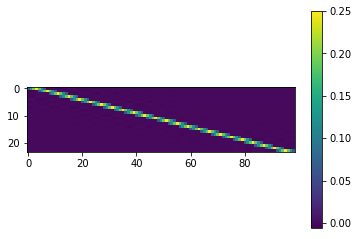

In [10]:
plt.imshow(GLOBALR)
plt.colorbar()

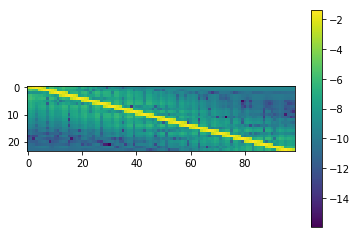

In [11]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

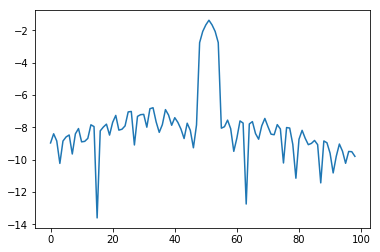

In [12]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
2.3559053859167074
L2 norm: 
0.10980232673684599
H1 norm: 
1.665809122904188
Energy norm: 
0.18760549662493595
L2 norm: 
0.1552839396513695
H1 norm: 
0.18700589989223185
0.6772961917072327


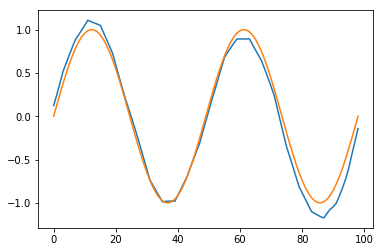

In [13]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)